In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from data_utils import *
from eda_utils import *
from train_utils import *
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
import pickle
import os

import warnings
# Ignore warnings
warnings.filterwarnings("ignore")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Data Preprocessing

## Dataset creation

In [3]:
phyt_cod_path = 'data/PHYT_COD_ForDvirLafer.csv'
phyto_path = 'data/Phyto4DvirLafer.csv'

biomass_by_week_year_group = get_biomass_data(phyt_cod_path, phyto_path)

In [4]:
fp_path = 'data/FP_2017_ForDvirLafer.csv'

fp_df = get_fluorprobe_data(fp_path)

## Splitting to test temporarily & Extracting probe's test data

In [5]:
biomass_test = biomass_by_week_year_group[(biomass_by_week_year_group['year'] == 2022) & (biomass_by_week_year_group['month'] >= 3)]
biomass_val = biomass_by_week_year_group[(biomass_by_week_year_group['year'] == 2022) & (biomass_by_week_year_group['month'] < 3)]
biomass_train = biomass_by_week_year_group[(~biomass_by_week_year_group.index.isin(biomass_test.index)) & (~biomass_by_week_year_group.index.isin(biomass_val.index))]

fp_test = fp_df[(fp_df['year'] == 2022) & (fp_df['month'] >= 3)]
fp_val = fp_df[(fp_df['year'] == 2022) & (fp_df['month'] < 3)]
fp_train = fp_df[(~fp_df.index.isin(fp_test.index)) & (~fp_df.index.isin(fp_val.index))]

merged_train = merge_fp_biomass_df(fp_train, biomass_train, is_train=True) # Merging fully
merged_val = merge_fp_biomass_df(fp_val, biomass_val, is_train=False) # Merging fully
merged_test = merge_fp_biomass_df(fp_test, biomass_test, is_train=False) # Merging only closest records by depth

In [6]:
merged_train = merged_train.drop(['Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta'], axis=1).reset_index(drop=True)

fluor_groups_map = {
    2: 'Bluegreen',
    3: 'Diatoms',
    4: 'Green Algae',
    6: 'Cryptophyta'
}

fluor_val_df = merged_val[['group_num', 'month', 'week', 'year', 'Depth', 'sum_biomass_ug_ml', 'Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta']].reset_index(drop=True)
merged_val = merged_val.drop(['Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta'], axis=1).reset_index(drop=True)

fluor_test_df = merged_test[['group_num', 'month', 'week', 'year', 'Depth', 'sum_biomass_ug_ml', 'Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta']].reset_index(drop=True)
merged_test = merged_test.drop(['Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta'], axis=1).reset_index(drop=True)

In [7]:
len(merged_train.sum_biomass_ug_ml.unique())

2043

In [8]:
biomass_estimation(merged_train)

In [9]:
len(merged_train.sum_biomass_ug_ml.unique())

55357

# EDA and Cleaning

In [10]:
merged_train.shape

(55389, 18)

In [11]:
merged_train = merged_train[merged_train['sum_biomass_ug_ml'] >= 0]

In [12]:
merged_train.shape

(53332, 18)

In [13]:
merged_train.loc[merged_train['Depth'] >= 21, 'Depth'] = 21
merged_val.loc[merged_val['Depth'] >= 21, 'Depth'] = 21
merged_test.loc[merged_test['Depth'] >= 21, 'Depth'] = 21

In [14]:
signals = ['red', 'green', 'yellow', 'orange', 'violet', 'brown', 'blue', 'pressure', 'temp_sample', 'yellow_sub', 'sum_biomass_ug_ml']

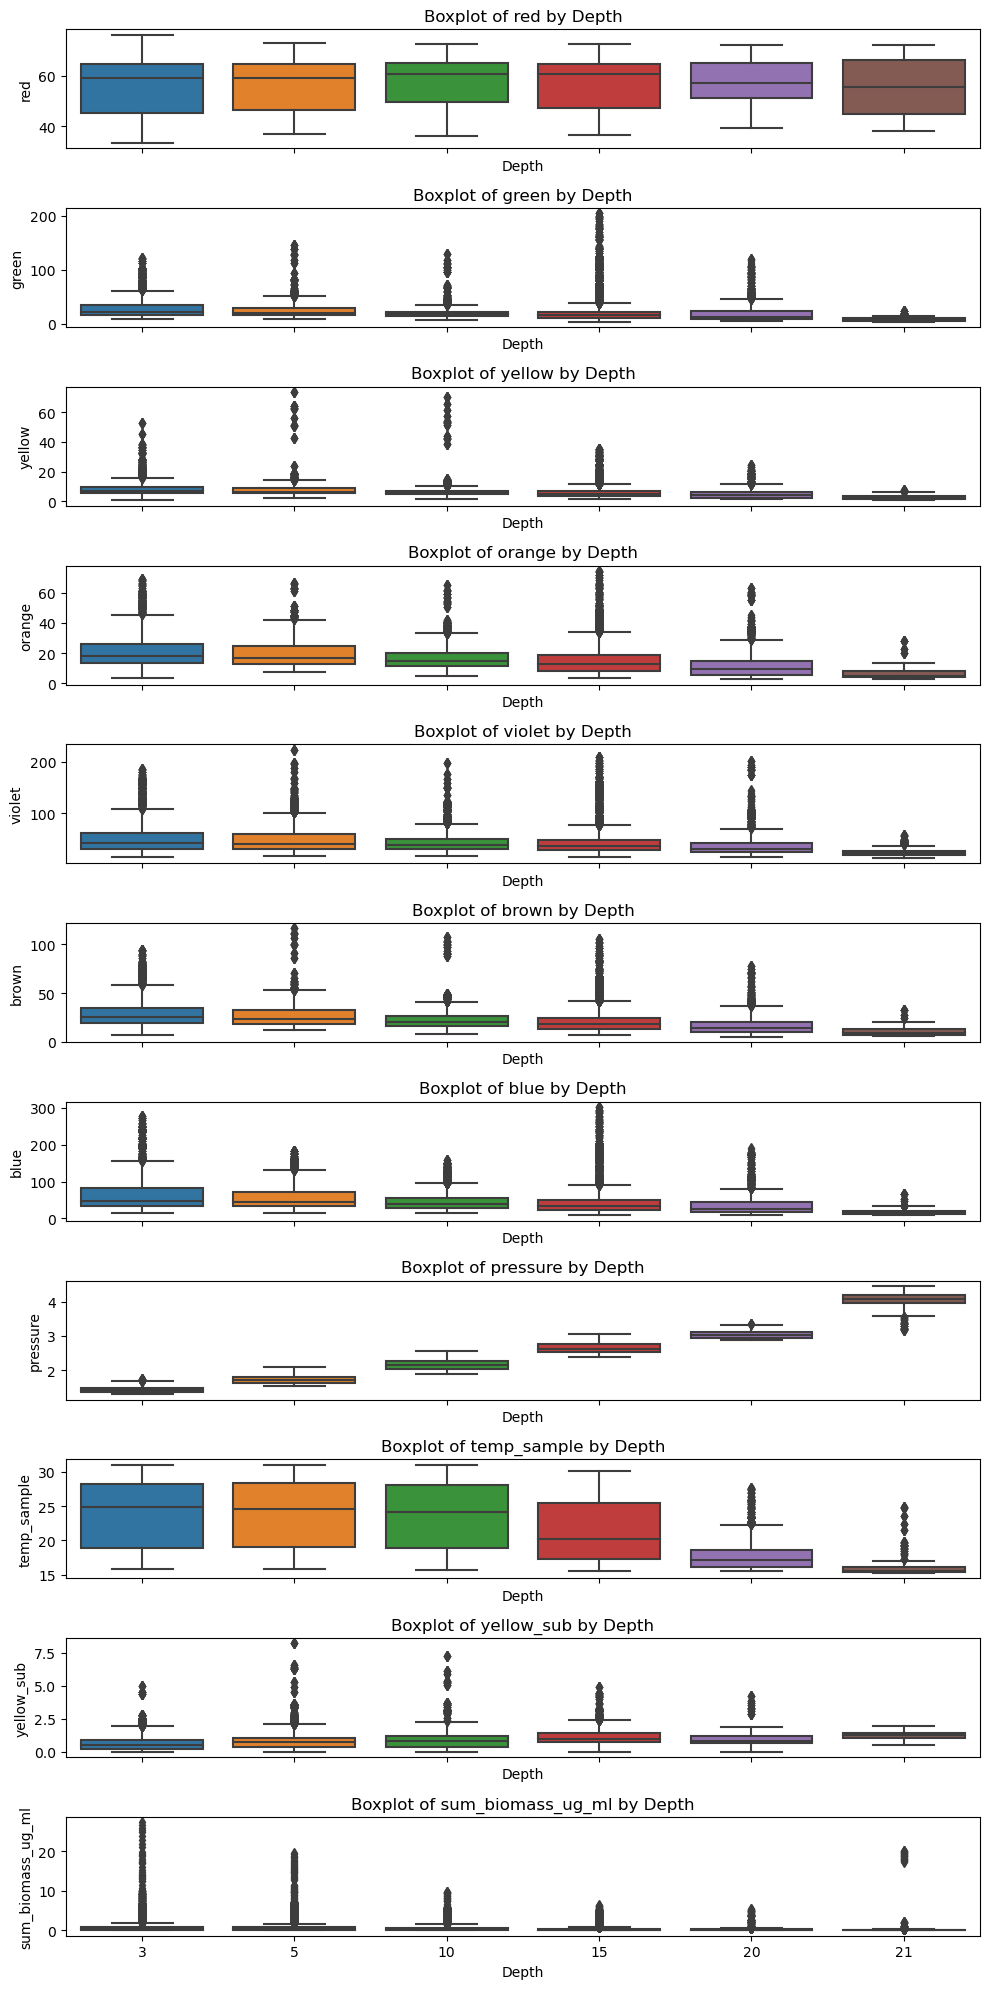

In [15]:
boxplot_by_depth(merged_train, signals, by_col='Depth')

In [16]:
signals.remove('sum_biomass_ug_ml')
signals.remove('pressure')
signals.remove('temp_sample')
boundaries = {
    'red': {'lower_bound': 0, 'upper_bound': 120},
    'green': {'lower_bound': 0, 'upper_bound': 100},
    'yellow': {'lower_bound': 0, 'upper_bound': 40},
    'orange': {'lower_bound': 0, 'upper_bound': 60},
    'violet': {'lower_bound': 0, 'upper_bound': 150},
    'brown': {'lower_bound': 0, 'upper_bound': 80},
    'blue': {'lower_bound': 0, 'upper_bound': 220},
    'yellow_sub': {'lower_bound': 0, 'upper_bound': 7}
}

filter_signals_by_boundaries(merged_train, signals, boundaries)

In [17]:
merged_train.shape

(52368, 18)

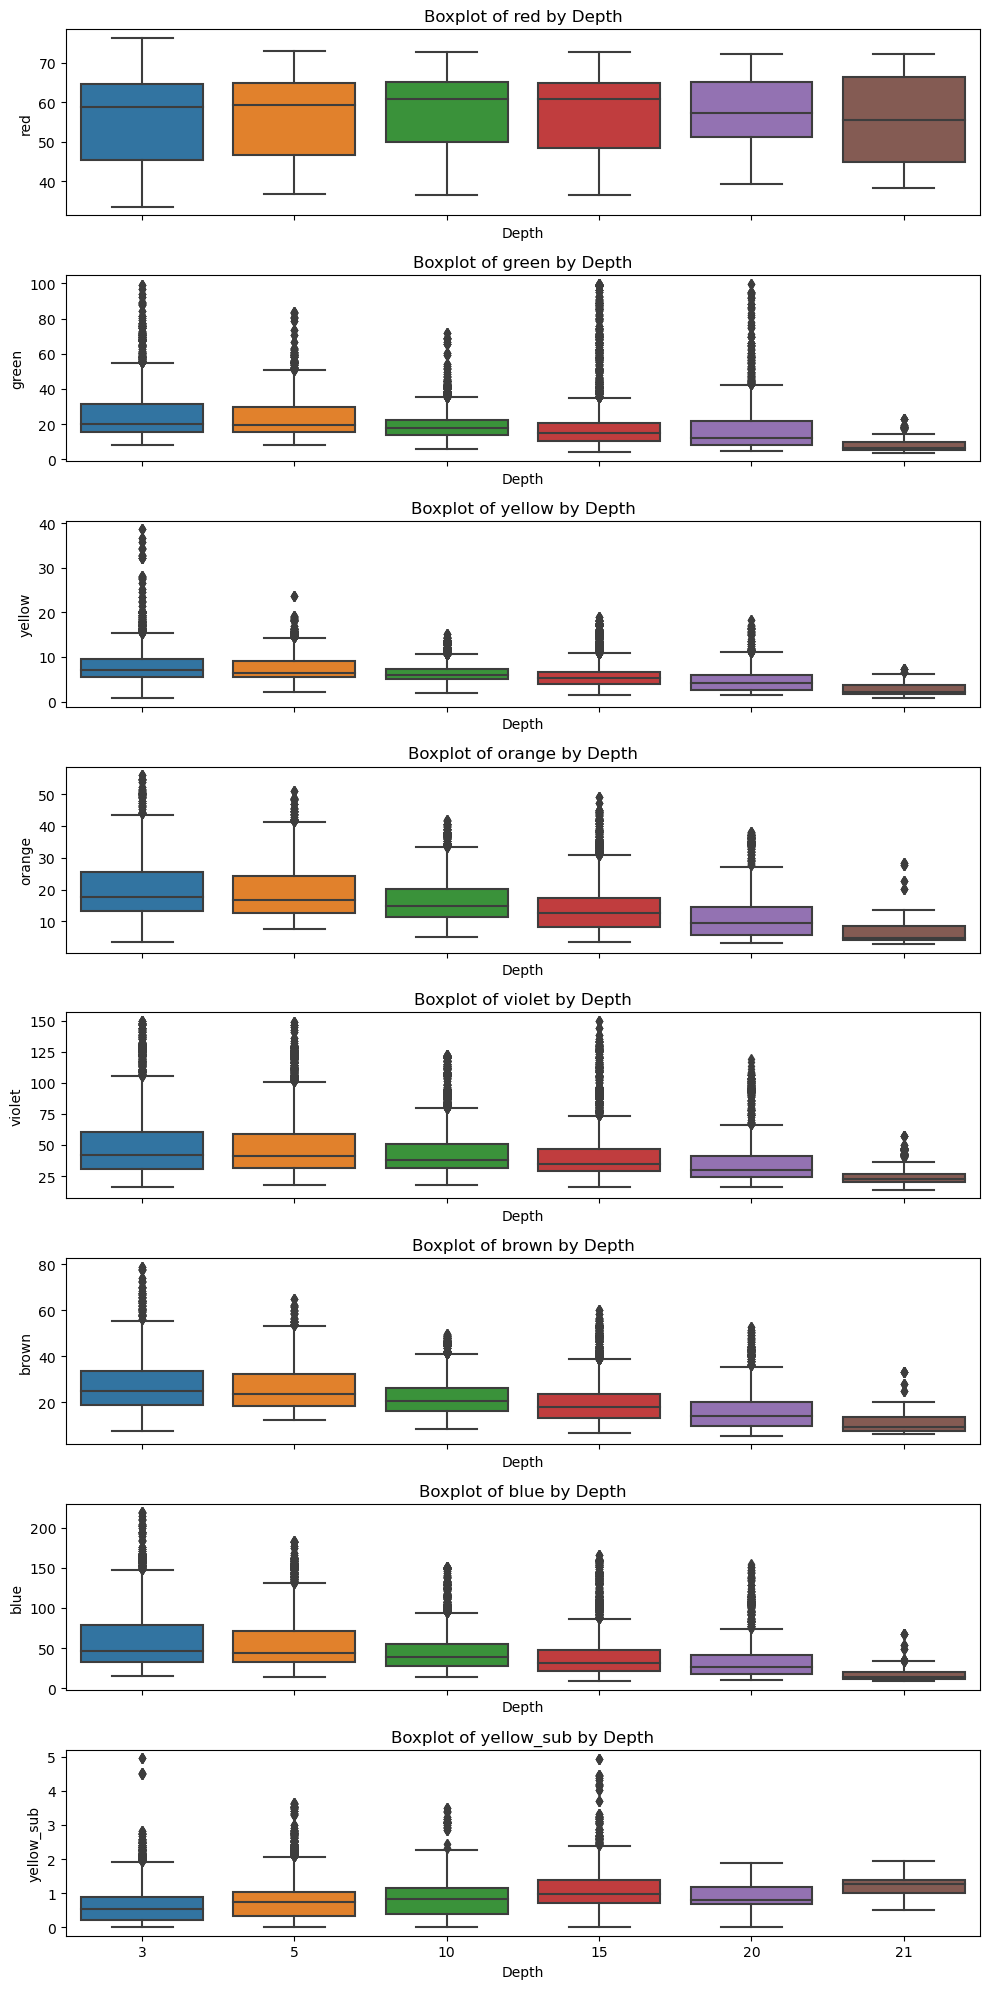

In [18]:
boxplot_by_depth(merged_train, signals, by_col='Depth')

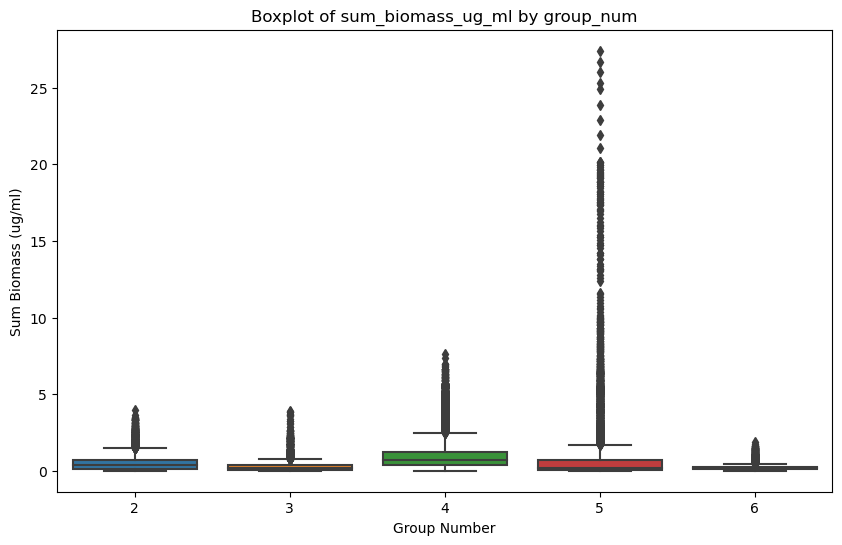

In [19]:
boxplot_biomass_by_group(merged_train)

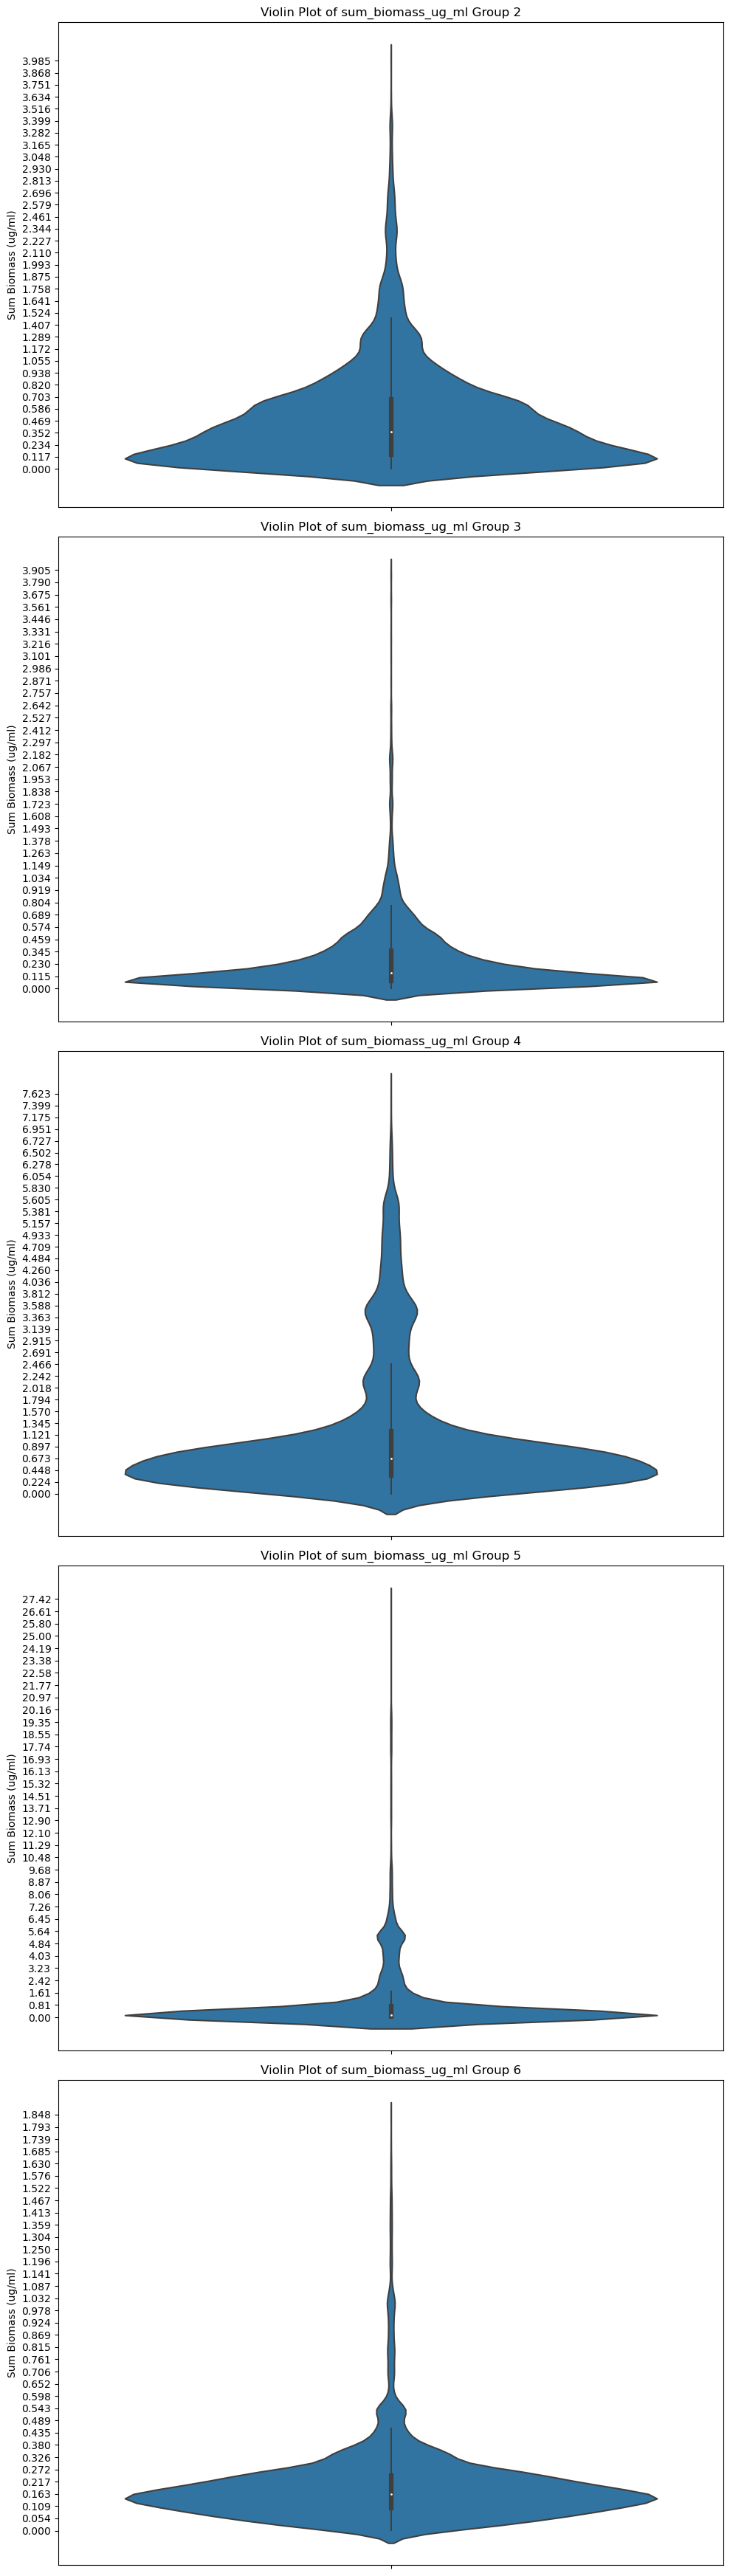

In [20]:
violin_biomass_by_group(merged_train)

In [21]:
# ranges_dict = {
#     2: (0, 0.5, 0.5),
#     3: (0, 0.3, 0.6),
#     4: (0.1, 1, 0.6),
#     5: (0, 0.8, 0.6),
#     6: (0, 0.25, 0.6)
# }

# undersample_merged = undersample_within_ranges(merged_train, ranges_dict)

In [22]:
# undersample_merged.shape

In [23]:
# merged_train.shape

In [24]:
# violin_biomass_by_group(undersample_merged)

In [25]:
# boundaries = {
#     2: (0.1, 2.5),
#     3: (0, 2),
#     4: (0, 5),
#     5: (0, 3),
#     6: (0.02, 1)
# }

# filter_biomass_by_group_boundaries(merged_train, boundaries)

In [26]:
# merged_train.shape

In [27]:
# undersample_merged['sum_biomass_ug_ml'] = undersample_merged['sum_biomass_ug_ml'].apply(np.log)
# boxplot_biomass_by_group(undersample_merged)
# undersample_merged['sum_biomass_ug_ml'] = undersample_merged['sum_biomass_ug_ml'].apply(np.exp)

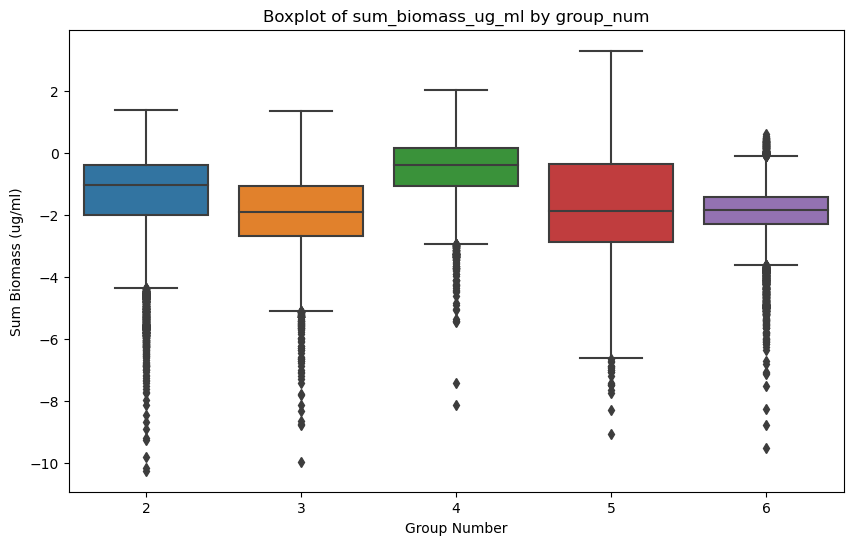

In [28]:
merged_train['sum_biomass_ug_ml'] = merged_train['sum_biomass_ug_ml'].apply(np.log)
boxplot_biomass_by_group(merged_train)

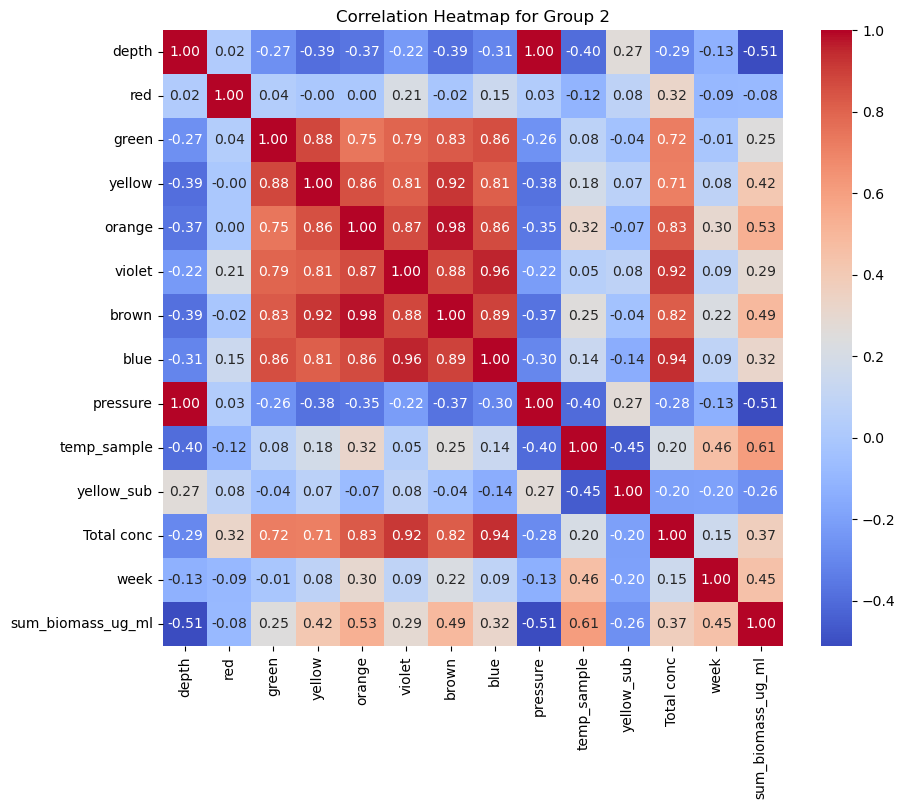

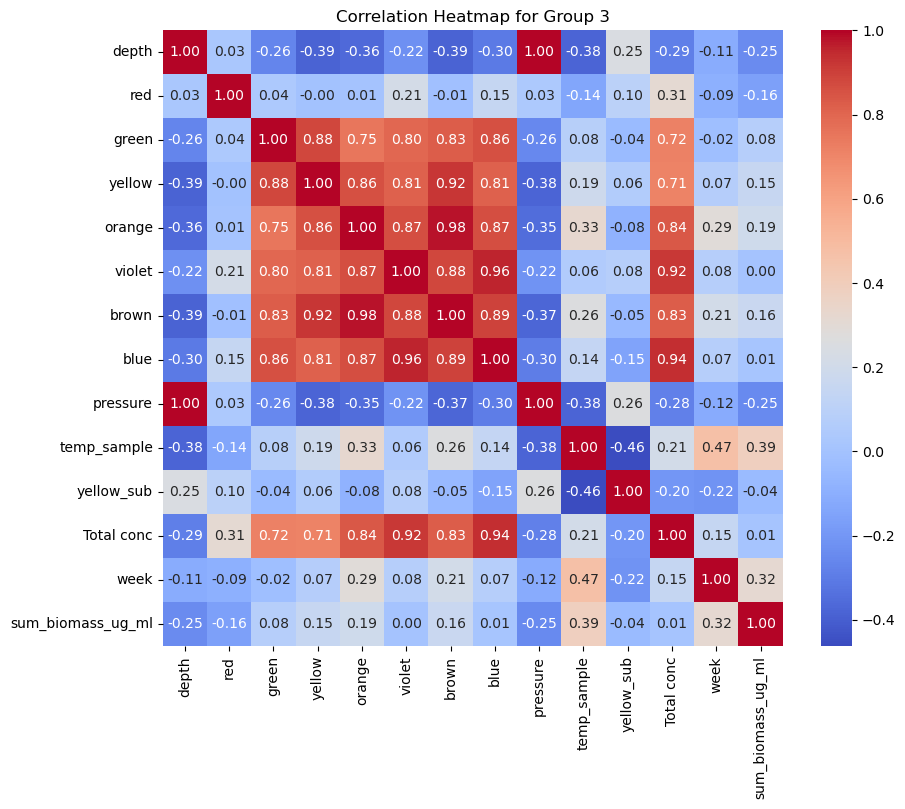

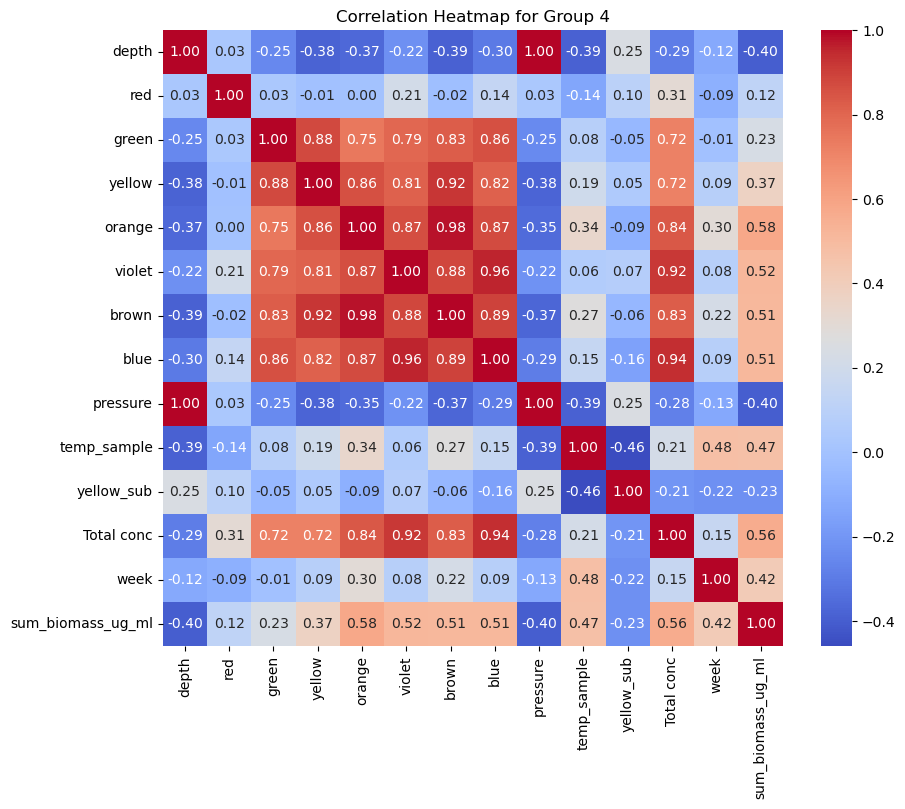

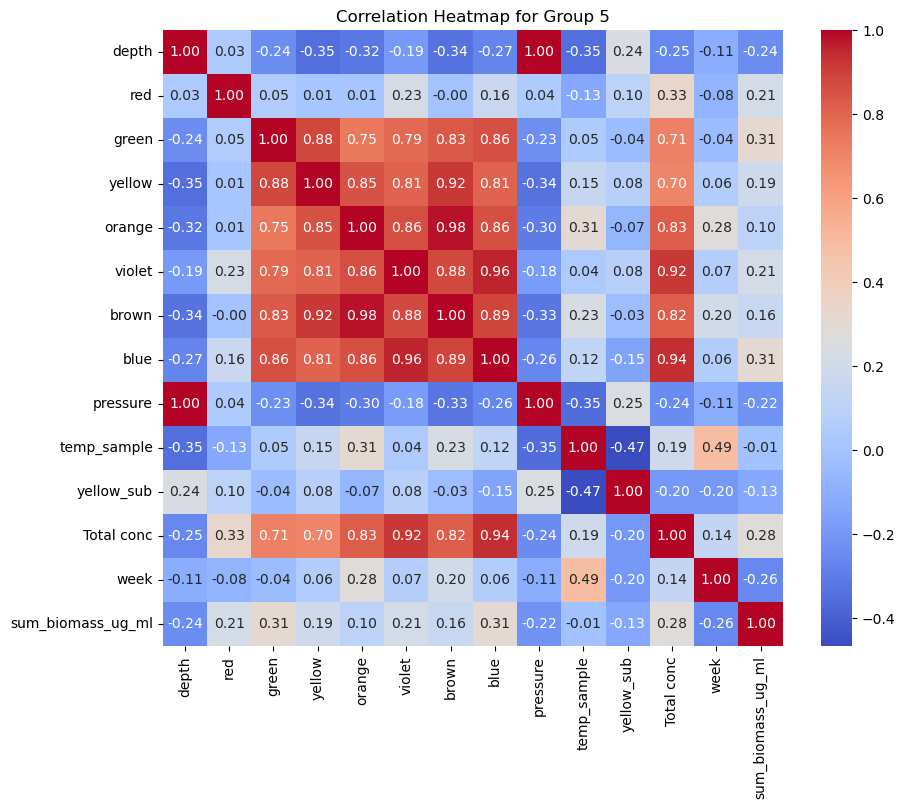

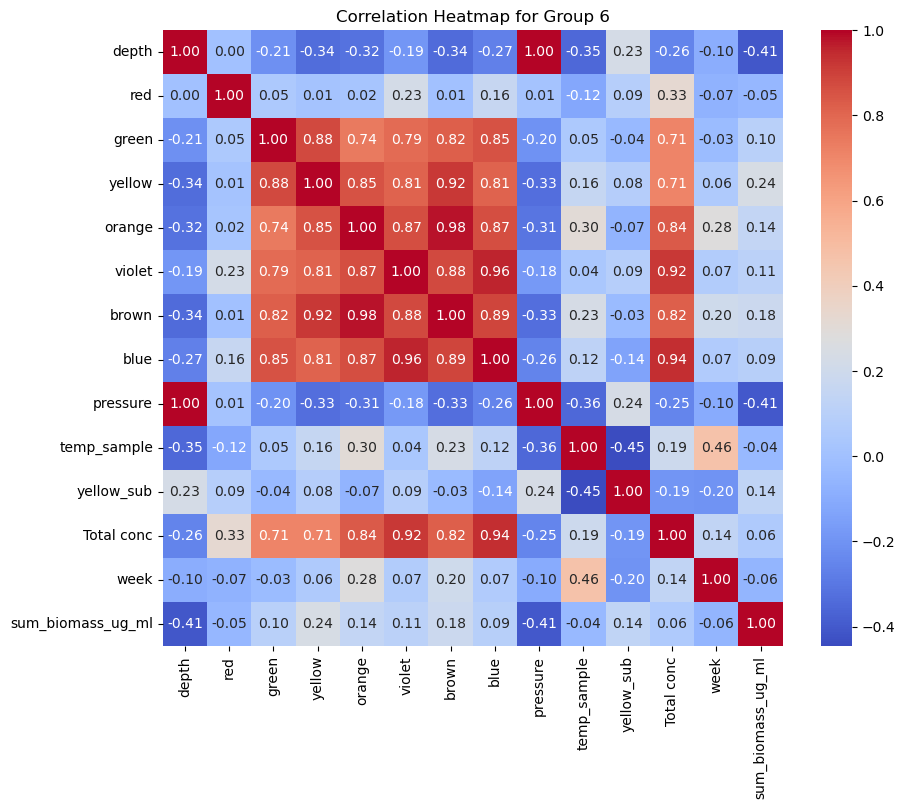

In [29]:
correlation_per_group(merged_train)

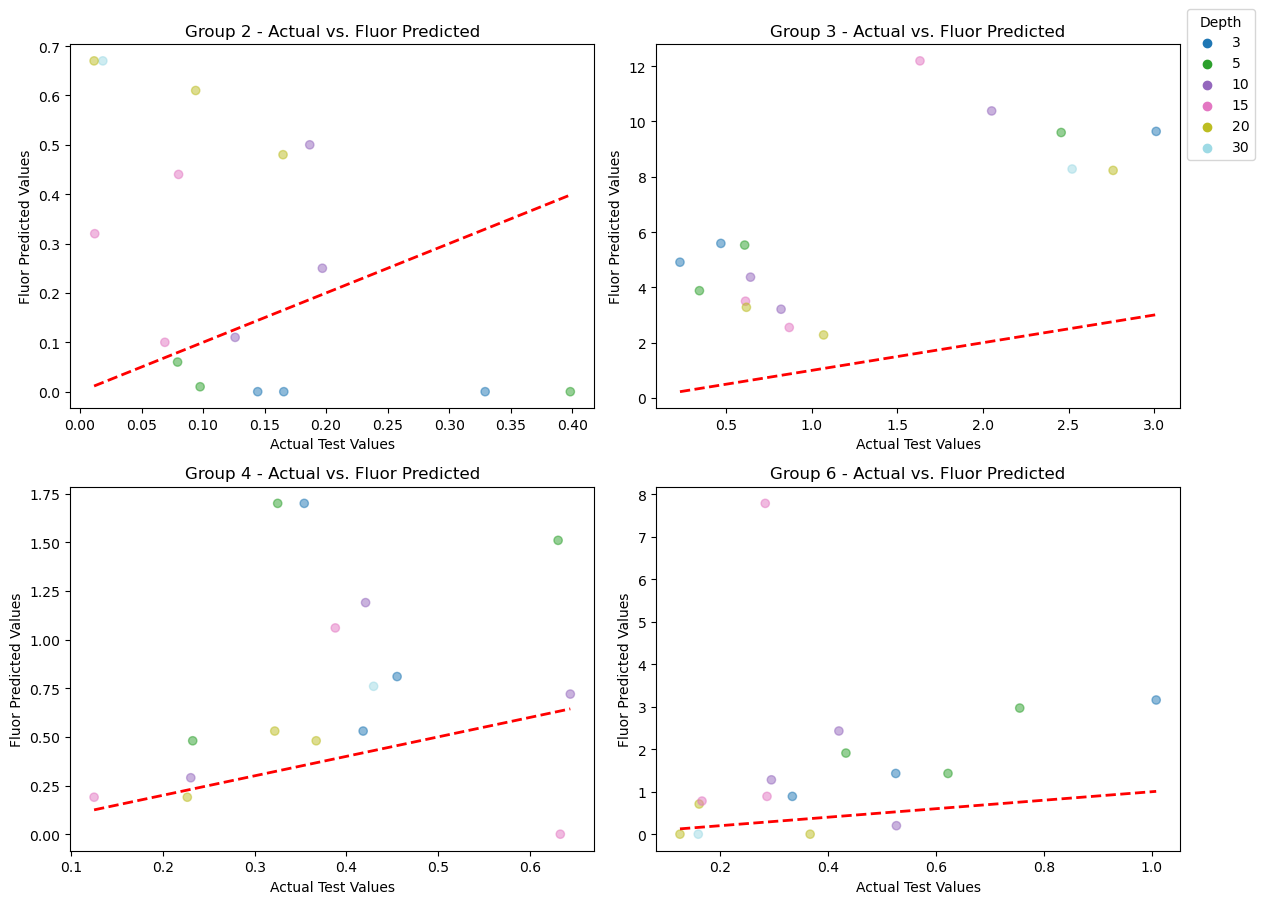

In [30]:
plot_fluorprobe_prediction(fluor_val_df, fluor_groups_map)

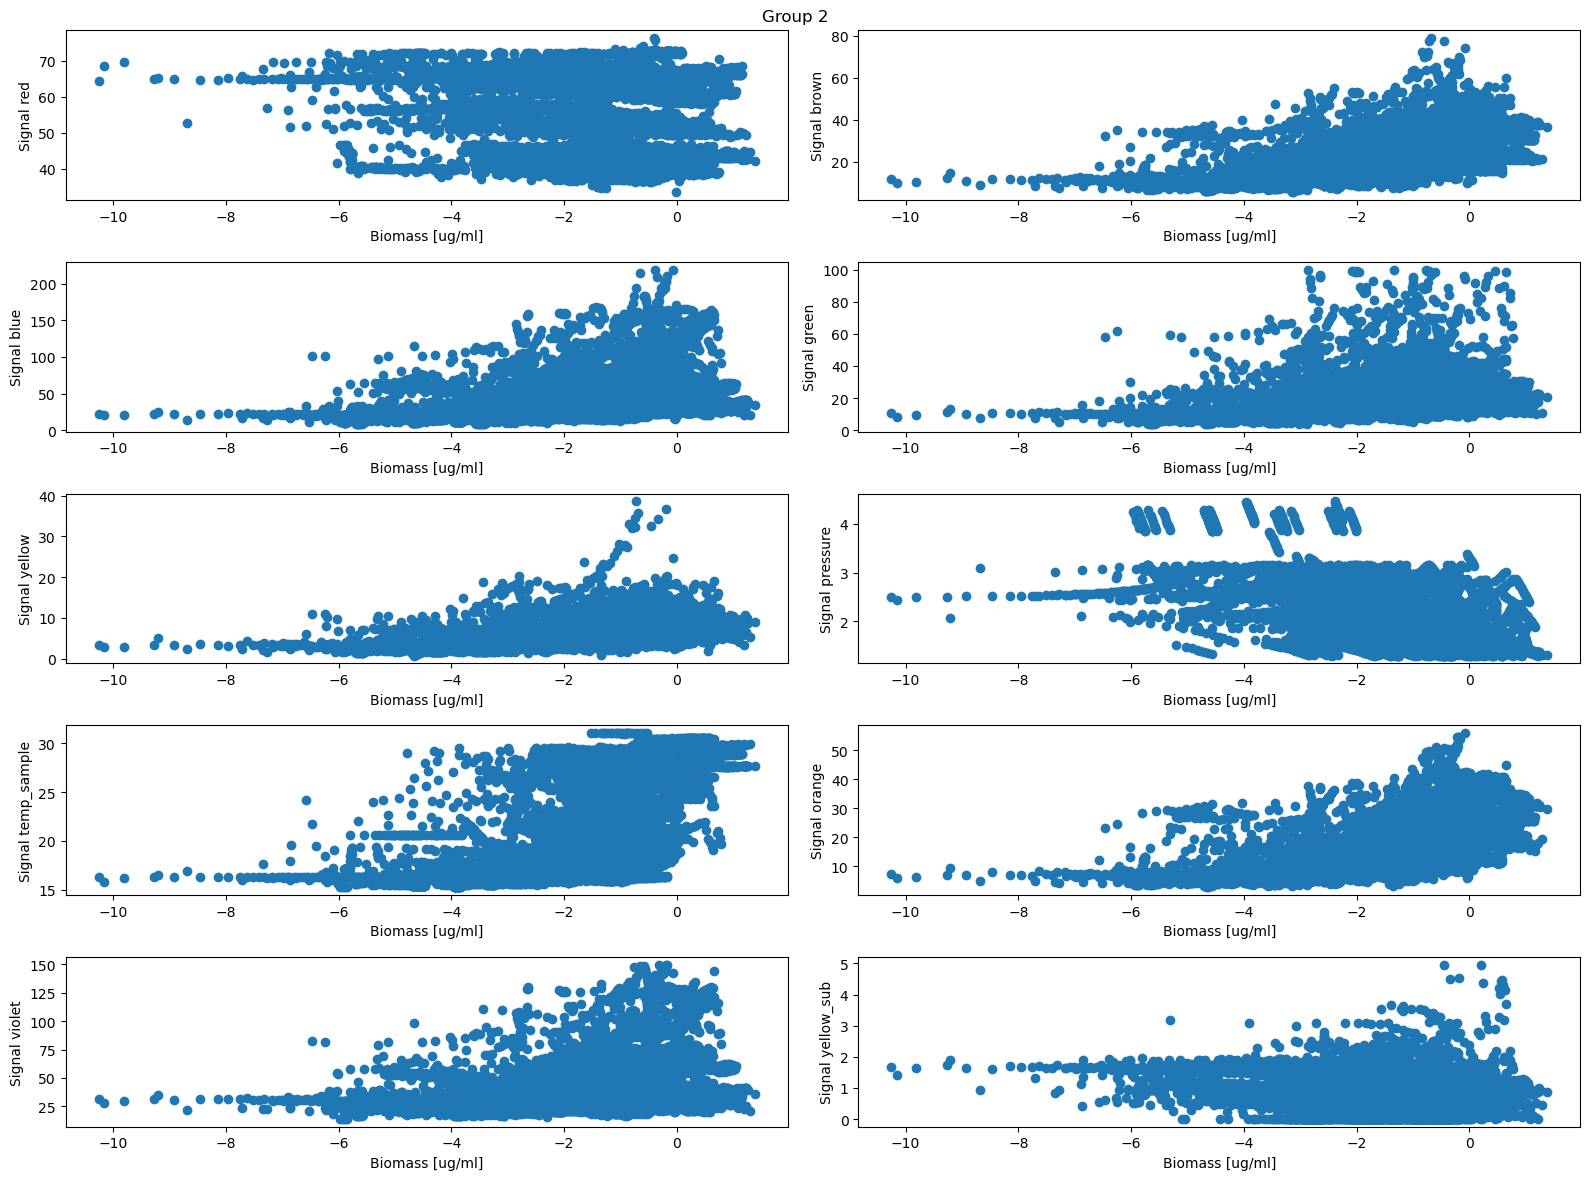

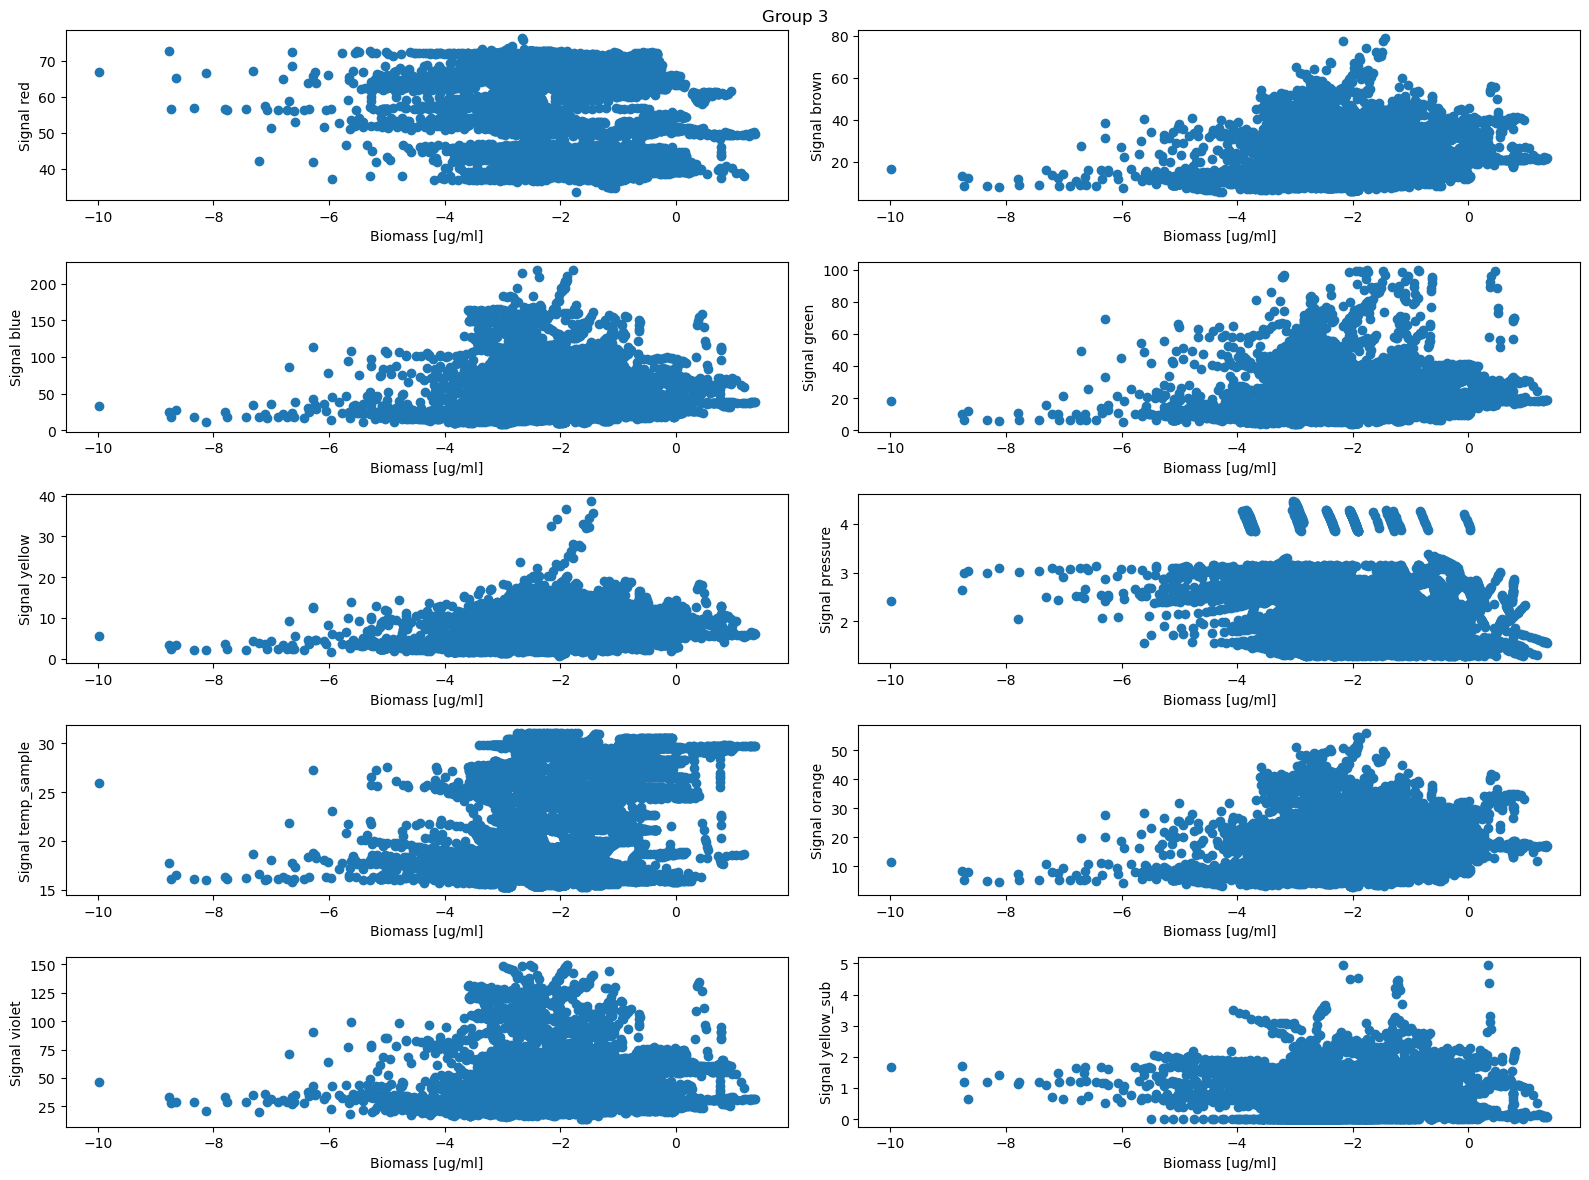

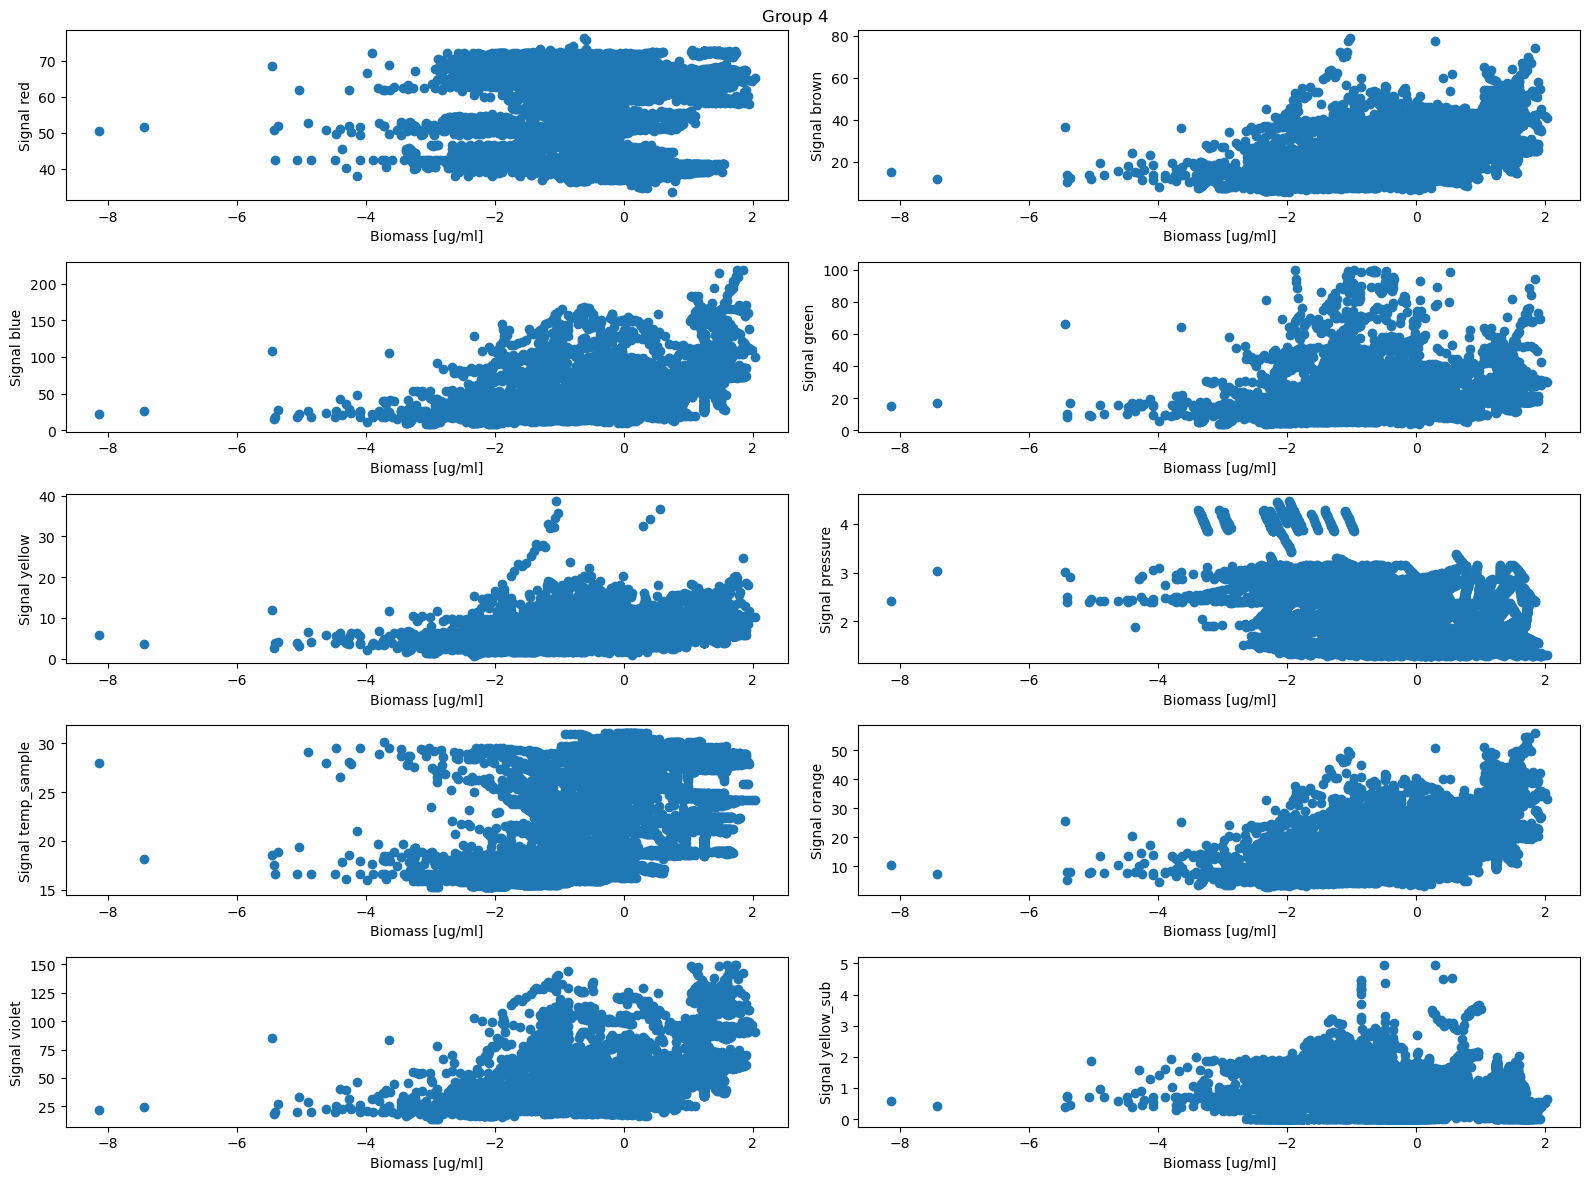

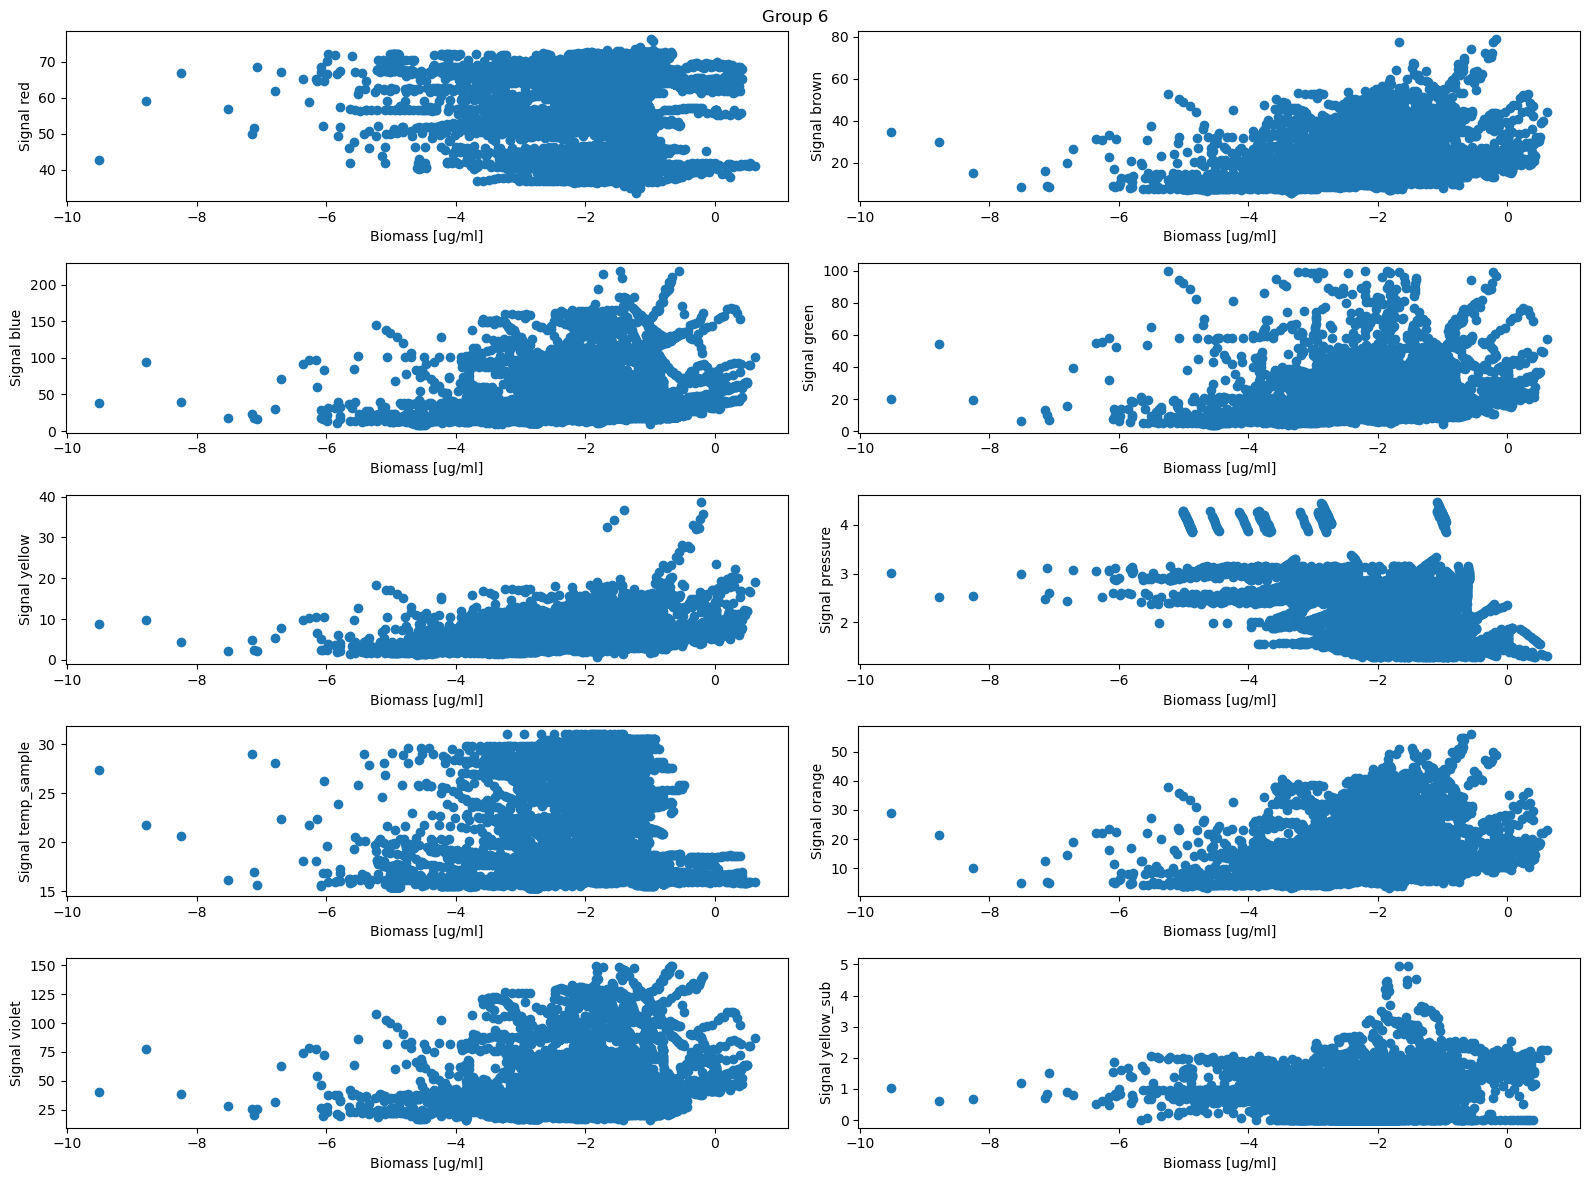

In [31]:
plot_corr_per_feature_per_group(merged_train, fluor_groups_map)

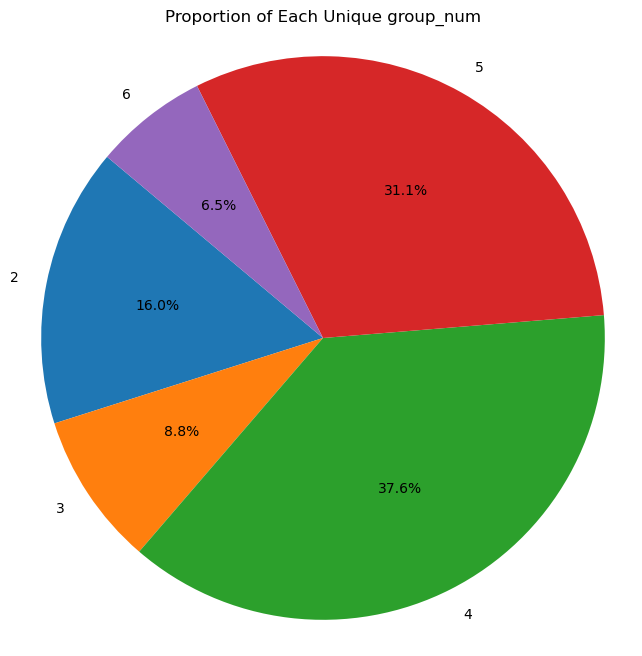

In [32]:
merged_train['sum_biomass_ug_ml'] = merged_train['sum_biomass_ug_ml'].apply(np.exp)
groups_pie_chart(merged_train, by_biomass=True)

In [33]:
merged_train = merged_train.drop(['year', 'Depth', 'depth', 'week', 'month'], axis=1)
# undersample_merged = undersample_merged.drop(['year', 'Depth', 'depth', 'week', 'month'], axis=1)
# merged_test = merged_test.drop(['year', 'Depth', 'week', 'depth_discrete', 'month'], axis=1)
# merged_val = merged_val.drop(['year', 'Depth', 'week', 'depth_discrete', 'month'], axis=1)

In [34]:
import smogn
import seaborn

In [37]:
group_3 = merged_train[merged_train['group_num'] == 3].reset_index(drop=True)

In [39]:
## conduct smogn
group_3_smogn = smogn.smoter(
    
    data = group_3,  ## pandas dataframe
    y = 'sum_biomass_ug_ml'  ## string ('header name')
)
     

r_index: 100%|#############################| 1590/1590 [00:02<00:00, 587.19it/s]


In [42]:
group_3.shape

(10755, 13)

In [40]:
group_3_smogn.shape

(8861, 13)

<Axes: xlabel='sum_biomass_ug_ml', ylabel='Density'>

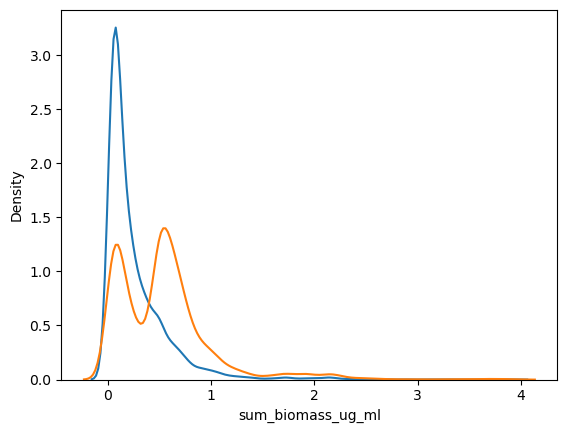

In [41]:
## plot y distribution 
seaborn.kdeplot(group_3['sum_biomass_ug_ml'], label = "Original")
seaborn.kdeplot(group_3_smogn['sum_biomass_ug_ml'], label = "Modified")

# Training models and evaluating

In [44]:
pickled_params = 'best_grid_params.pkl'
do_search = not os.path.exists(pickled_params)

def two_scorer(mse=False):
    score = mean_squared_error if mse else r2_score
    return make_scorer(score, greater_is_better=mse==False)

In [45]:
if do_search:
#     param_grid_per_model = {'xgb': {
#         "model__n_estimators": [100, 300, 500], # Number of boosting rounds
#         "model__learning_rate": [0.01, 0.1, 0.2], # Step size shrinkage
#         "model__max_depth": [3, 5, 7, 11], # Maximum depth of a tree,
#         'model__min_child_weight': [1, 5, 7],  # Minimum sum of instance weight needed in a child
#         "model__subsample": [0.2, 0.5, 1.0], # Fraction of samples used for fitting trees
#         "model__colsample_bytree": [0.2, 0.8, 1.0] # Fraction of features used for fitting trees
#     },
#     'svr':  {
#         "model__C": [0.1, 1, 10, 100], # Regularization parameter
#         "model__kernel": ["poly", "rbf"],
#         "model__degree": [1, 2, 3], # Degree of the polynomial kernel (for "poly" kernel)
#         "model__epsilon": [0.01, 0.1, 0.2], # Epsilon in the epsilon-SVR loss function
#         "model__tol": [1e-4, 1e-3, 1e-2] # Tolerance for stopping criterion
#     },
#     'elf': {
#         "model__alpha": [0.01, 0.1, 1, 10], # Regularization parameter
#         "model__l1_ratio": [0.2, 0.5, 0.8], # Mixing parameter between L1 and L2 regularization
#         "model__fit_intercept": [True, False], # Whether to calculate the intercept for the model
#     }}
    param_grid_per_model = {'xgb': {
        "model__n_estimators": [100, 300, 500], # Number of boosting rounds
        "model__max_depth": [2, 3, 5], # Maximum depth of a tree,
        "model__alpha": [0.01, 0.1, 1, 10], # L1 regularization term
        "model__lambda": [0, 0.2, 0.8], # Mixing parameter between L1 and L2 regularization
    },
    'svr':  {
        "model__C": [0.001, 0.1, 1, 10, 100], # Regularization parameter
        "model__tol": [1e-4, 1e-3, 1e-2] # Tolerance for stopping criterion
    },
    'elf': {
        "model__alpha": [0.01, 0.1, 1, 10], # Regularization parameter
        "model__l1_ratio": [0.2, 0.5, 0.8], # Mixing parameter between L1 and L2 regularization
    }}
    
    best_group_params_per_model = {}
    for model_name, param_grid in param_grid_per_model.items():
        best_group_params_per_model[model_name] = grid_search_cv(model_name, merged_train, param_grid=param_grid,
                                                                scoring_method=two_scorer(mse=True))
    
    with open(pickled_params, 'wb') as f:
        pickle.dump(best_group_params_per_model, f)
    
    best_group_params_per_model_fixed = {}
    for model_name, kwargs_per_group in best_group_params_per_model.items():
        best_group_params_per_model_fixed[model_name] = {}
        for group_num in kwargs_per_group.keys():
            best_group_params_per_model_fixed[model_name][group_num] = {}
            kwargs = kwargs_per_group[group_num]
            for param, val in kwargs.items():
                fixed_param = param.split('model__')[1]
                best_group_params_per_model_fixed[model_name][group_num][fixed_param] = val


    with open(pickled_params, 'wb') as f:
        pickle.dump(best_group_params_per_model_fixed, f)

else:
    with open(pickled_params, 'rb') as f:
        best_group_params_per_model_fixed = pickle.load(f)

In [47]:
regression_models = {}
for model_name, best_group_params_fixed in best_group_params_per_model_fixed.items():
    regression_models[model_name], _ = train(model_name, merged_train, group_kwargs=best_group_params_per_model_fixed, test_size=0.0,
                                             biomass_fn=np.log)
    

regression_models['lr'], _ = train('lr', merged_train, test_size=0.0, biomass_fn=np.log)

In [48]:
regression_models.pop('lr')
regression_models.pop('elf')

{2: Pipeline(steps=[('scaler', StandardScaler()), ('model', ElasticNet())]),
 3: Pipeline(steps=[('scaler', StandardScaler()), ('model', ElasticNet())]),
 4: Pipeline(steps=[('scaler', StandardScaler()), ('model', ElasticNet())]),
 5: Pipeline(steps=[('scaler', StandardScaler()), ('model', ElasticNet())]),
 6: Pipeline(steps=[('scaler', StandardScaler()), ('model', ElasticNet())])}

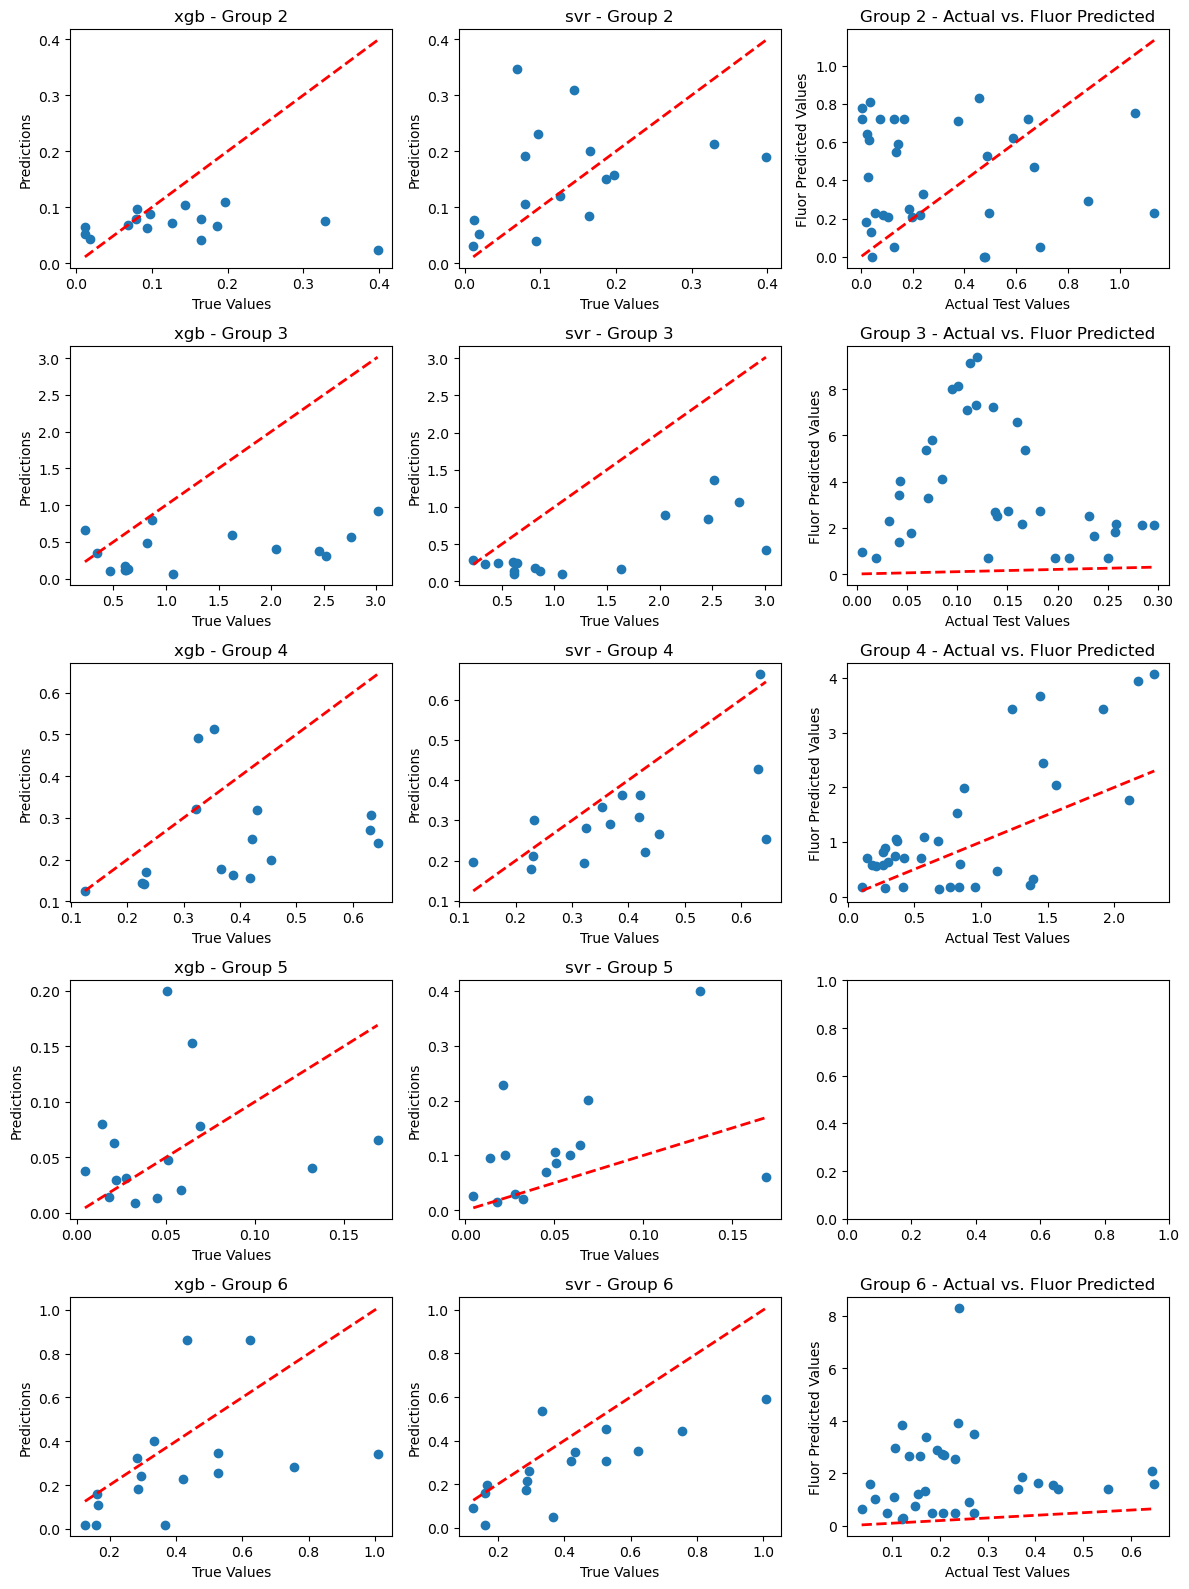

In [49]:
comparing_df = compare_all_models(regression_models, merged_val.drop(['year', 'Depth', 'week', 'month'], axis=1), fluor_test_df, fluor_groups_map, predictions_fn=np.exp, model_names=['xgb', 'svr'])

In [50]:
comparing_df.groupby('Model').mean()[['RMSE', 'MAPE']]

RMSE       MAPE
Model                     
FP     2.010829  16.578301
svr    0.334022   0.948679
xgb    0.384518   0.821281

In [51]:
comparing_df[comparing_df['Model'] == 'xgb']

Group Model      RMSE  R-squared      MAPE
0       2   xgb  0.127450  -0.501130  0.930965
3       3   xgb  1.240809  -0.804148  0.747041
6       4   xgb  0.214083  -1.112759  0.416210
9       5   xgb  0.062941  -1.096242  1.517554
11      6   xgb  0.277307  -0.420070  0.494635

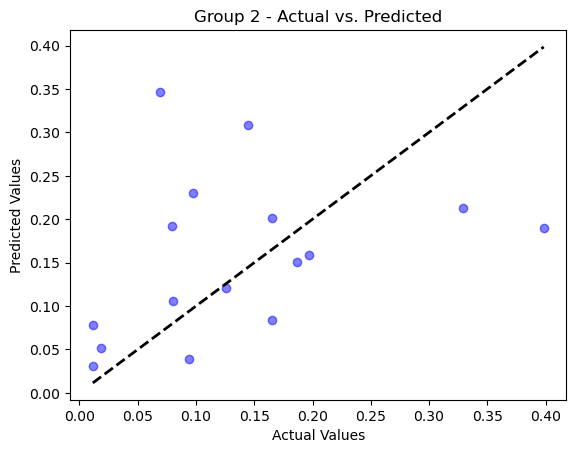

Results for group_num 2:
MSE: 0.013250169564184552
R-squared: -0.2244946314820988



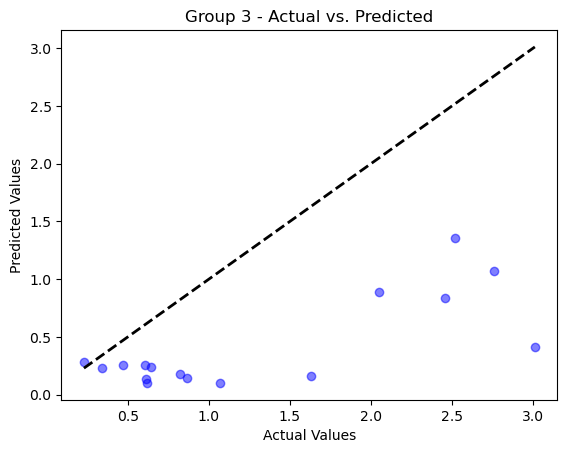

Results for group_num 3:
MSE: 1.2378252013620517
R-squared: -0.4505138459881224



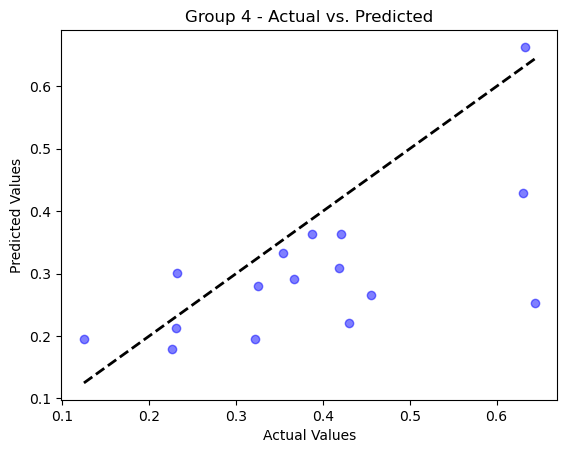

Results for group_num 4:
MSE: 0.020415144420414384
R-squared: 0.058897933010416126



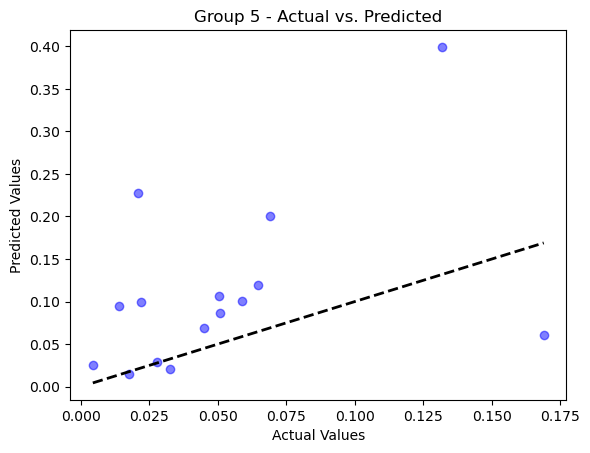

Results for group_num 5:
MSE: 0.011097771367235424
R-squared: -4.87233551579985



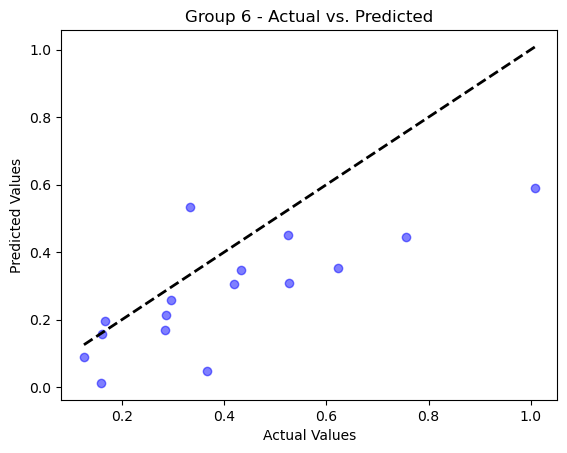

Results for group_num 6:
MSE: 0.037711844927747054
R-squared: 0.30358675510973276

Total MSE: 0.2640600263283266, Total R-squared: -1.0369718610299843


In [52]:
eval_test(regression_models['svr'], merged_val.drop(['week', 'month', 'year', 'Depth'], axis=1), prediction_fn=np.exp)

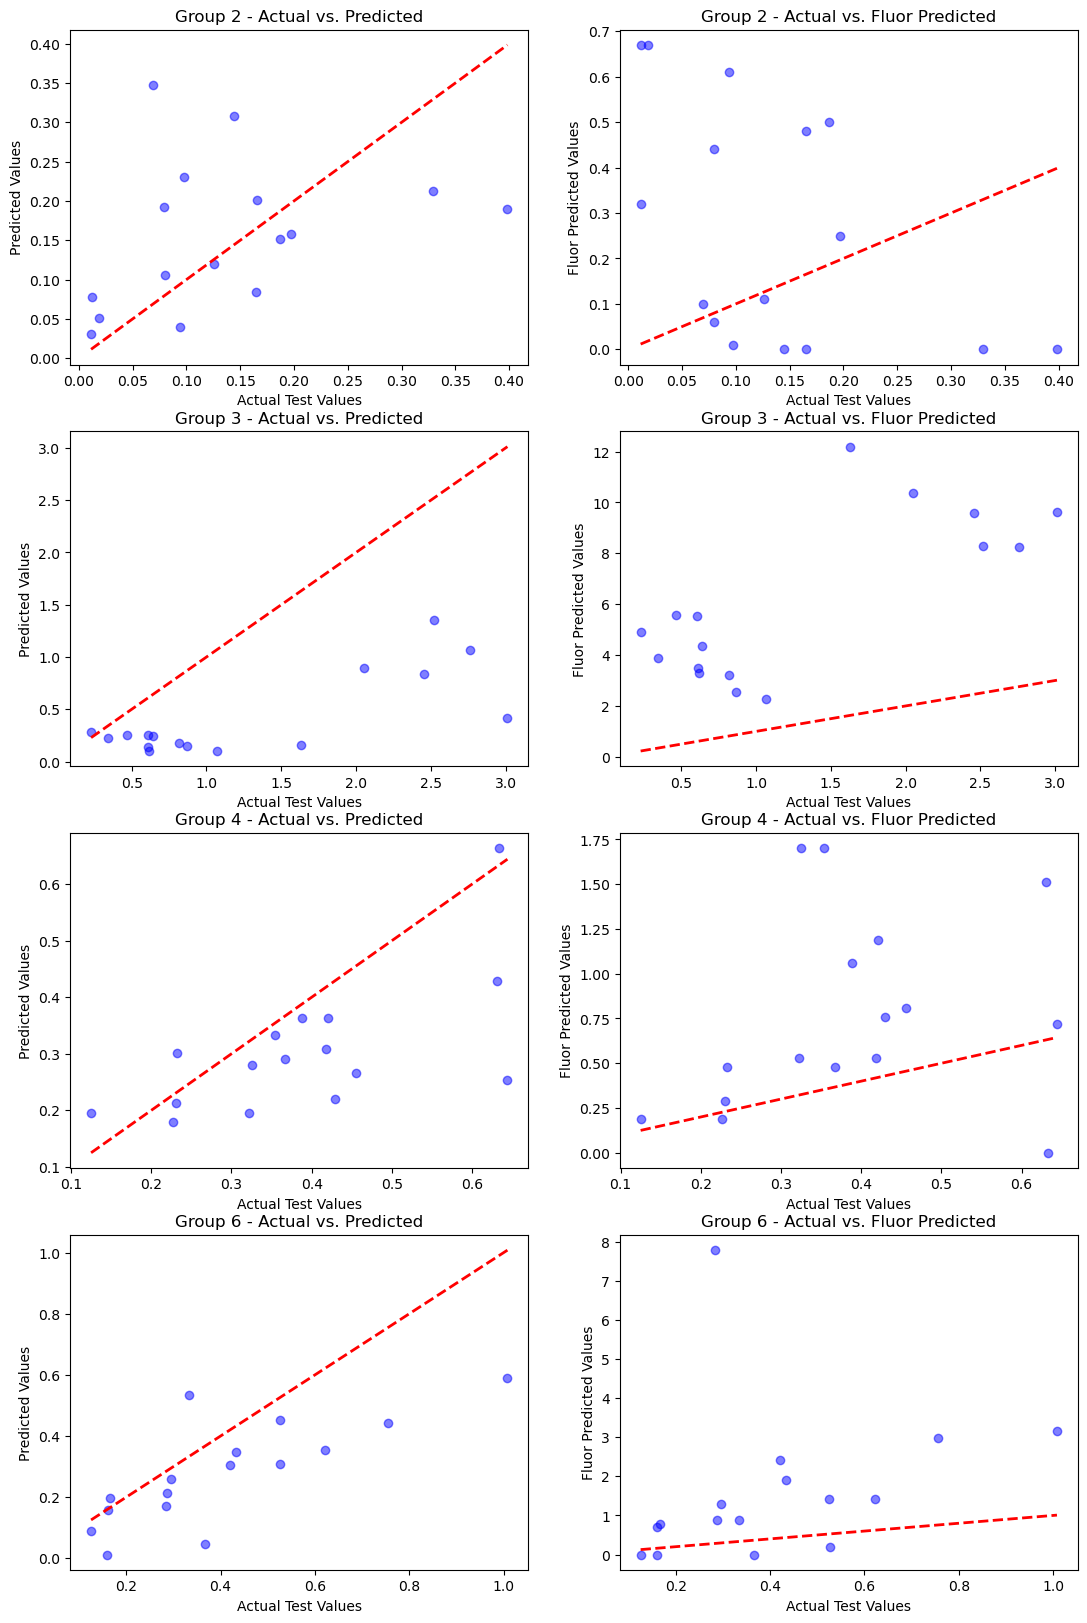

In [54]:
compare_to_fluor(regression_models['svr'], merged_val.drop(['week', 'month', 'year', 'Depth'], axis=1), fluor_groups_map, fluor_val_df, predict_fn=np.exp)

In [55]:
compare_by_mpe(merged_val, regression_models, predict_fn=np.exp)

Model         2          3          4         5          6
0   xgb  5.345828  24.649874  12.069362  5.061026  10.882341
1   svr  6.109543  23.714703   9.992070  5.835080   6.829568

In [56]:
calc_mpe_fp(fluor_val_df)

Model          2          3         4         5          6
0    FP  95.651021  67.199187  9.672783  0.048694  16.853845

In [57]:
calc_mpe_fp(fluor_test_df)[[2, 3, 4, 5, 6]].mean(axis=1)

0    35.674585
dtype: float64

# With SMOGN

********Group 2************
(10391, 13)


r_index: 100%|###############################| 692/692 [00:00<00:00, 791.94it/s]


(8889, 13)


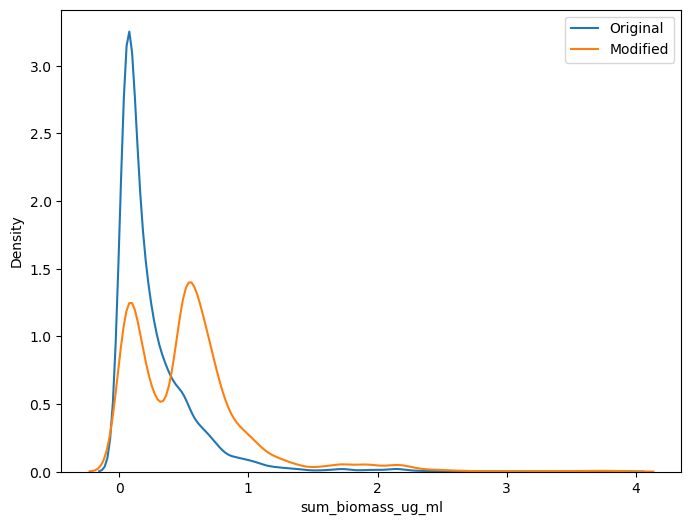

********Group 3************
(10755, 13)


r_index: 100%|#############################| 1590/1590 [00:01<00:00, 795.21it/s]


(8861, 13)


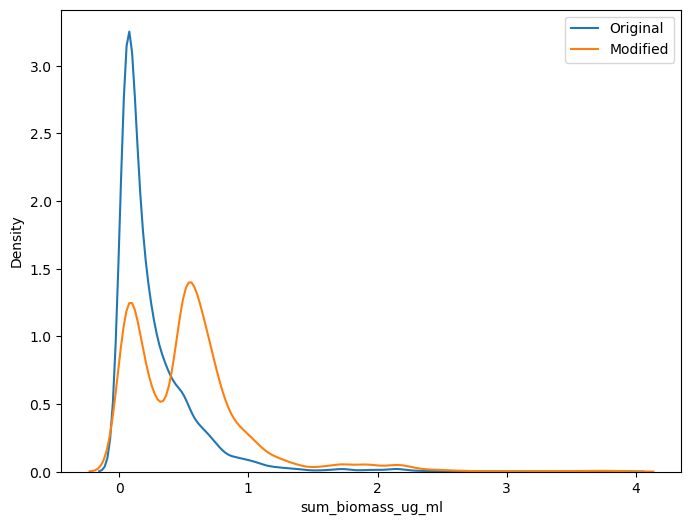

********Group 4************
(10955, 13)


r_index: 100%|#############################| 1116/1116 [00:01<00:00, 796.50it/s]


(8774, 13)


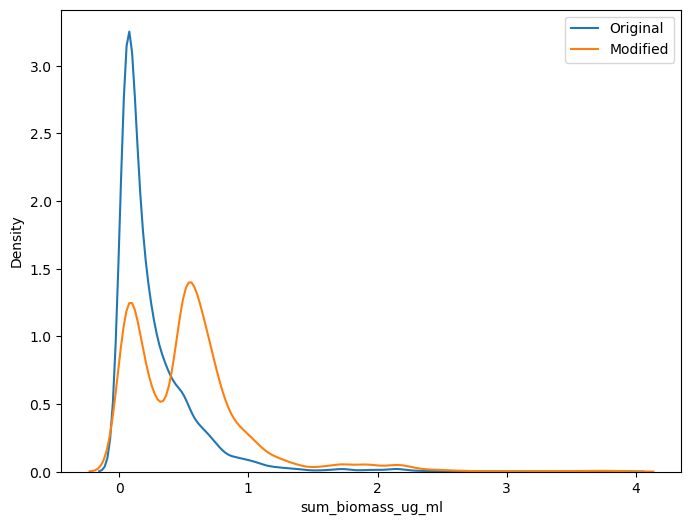

********Group 5************
(9687, 13)


r_index: 100%|###############################| 447/447 [00:00<00:00, 800.08it/s]


(7488, 13)


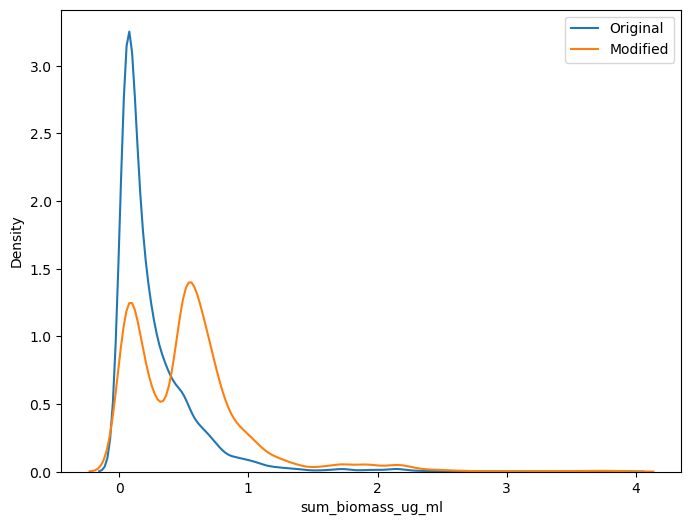

********Group 6************
(10580, 13)


r_index: 100%|###############################| 763/763 [00:00<00:00, 782.26it/s]


(9071, 13)


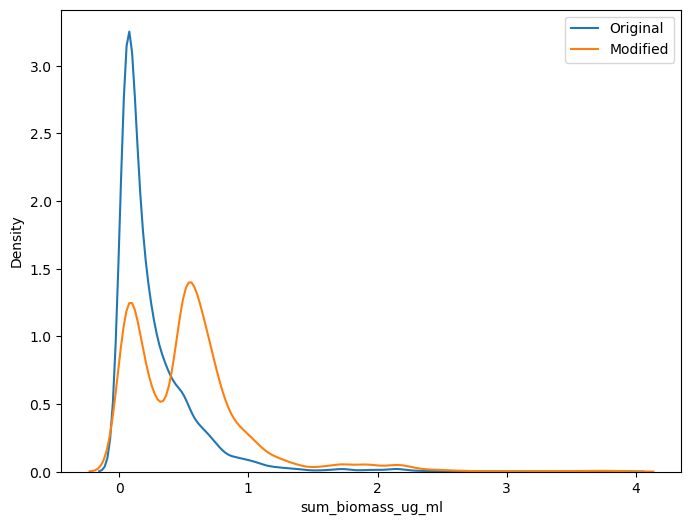

In [62]:
merged_train_smogn = []
for group_num in merged_train['group_num'].unique():
    group_df = merged_train[merged_train['group_num'] == group_num]
    print(f'********Group {group_num}************')
    print(group_df.shape)
    group_df = smogn.smoter(
        data = group_df.reset_index(drop=True),  ## pandas dataframe
        y = 'sum_biomass_ug_ml'  ## string ('header name')
    )
    print(group_df.shape)

    ## plot y distribution 
    plt.figure(figsize=(8, 6))
    seaborn.kdeplot(group_3['sum_biomass_ug_ml'], label = "Original")
    seaborn.kdeplot(group_3_smogn['sum_biomass_ug_ml'], label = "Modified")
    plt.legend()
    plt.show()
    
    merged_train_smogn.append(group_df)
    
    
merged_train_smogn_concat = pd.concat(merged_train_smogn, ignore_index=True)

In [65]:
regression_models_smogn = {}
for model_name, best_group_params_fixed in best_group_params_per_model_fixed.items():
    regression_models_smogn[model_name], _ = train(model_name, merged_train_smogn_concat, group_kwargs=best_group_params_per_model_fixed, test_size=0.0,
                                             biomass_fn=np.log)
    

regression_models_smogn['lr'], _ = train('lr', merged_train_smogn_concat, test_size=0.0, biomass_fn=np.log)

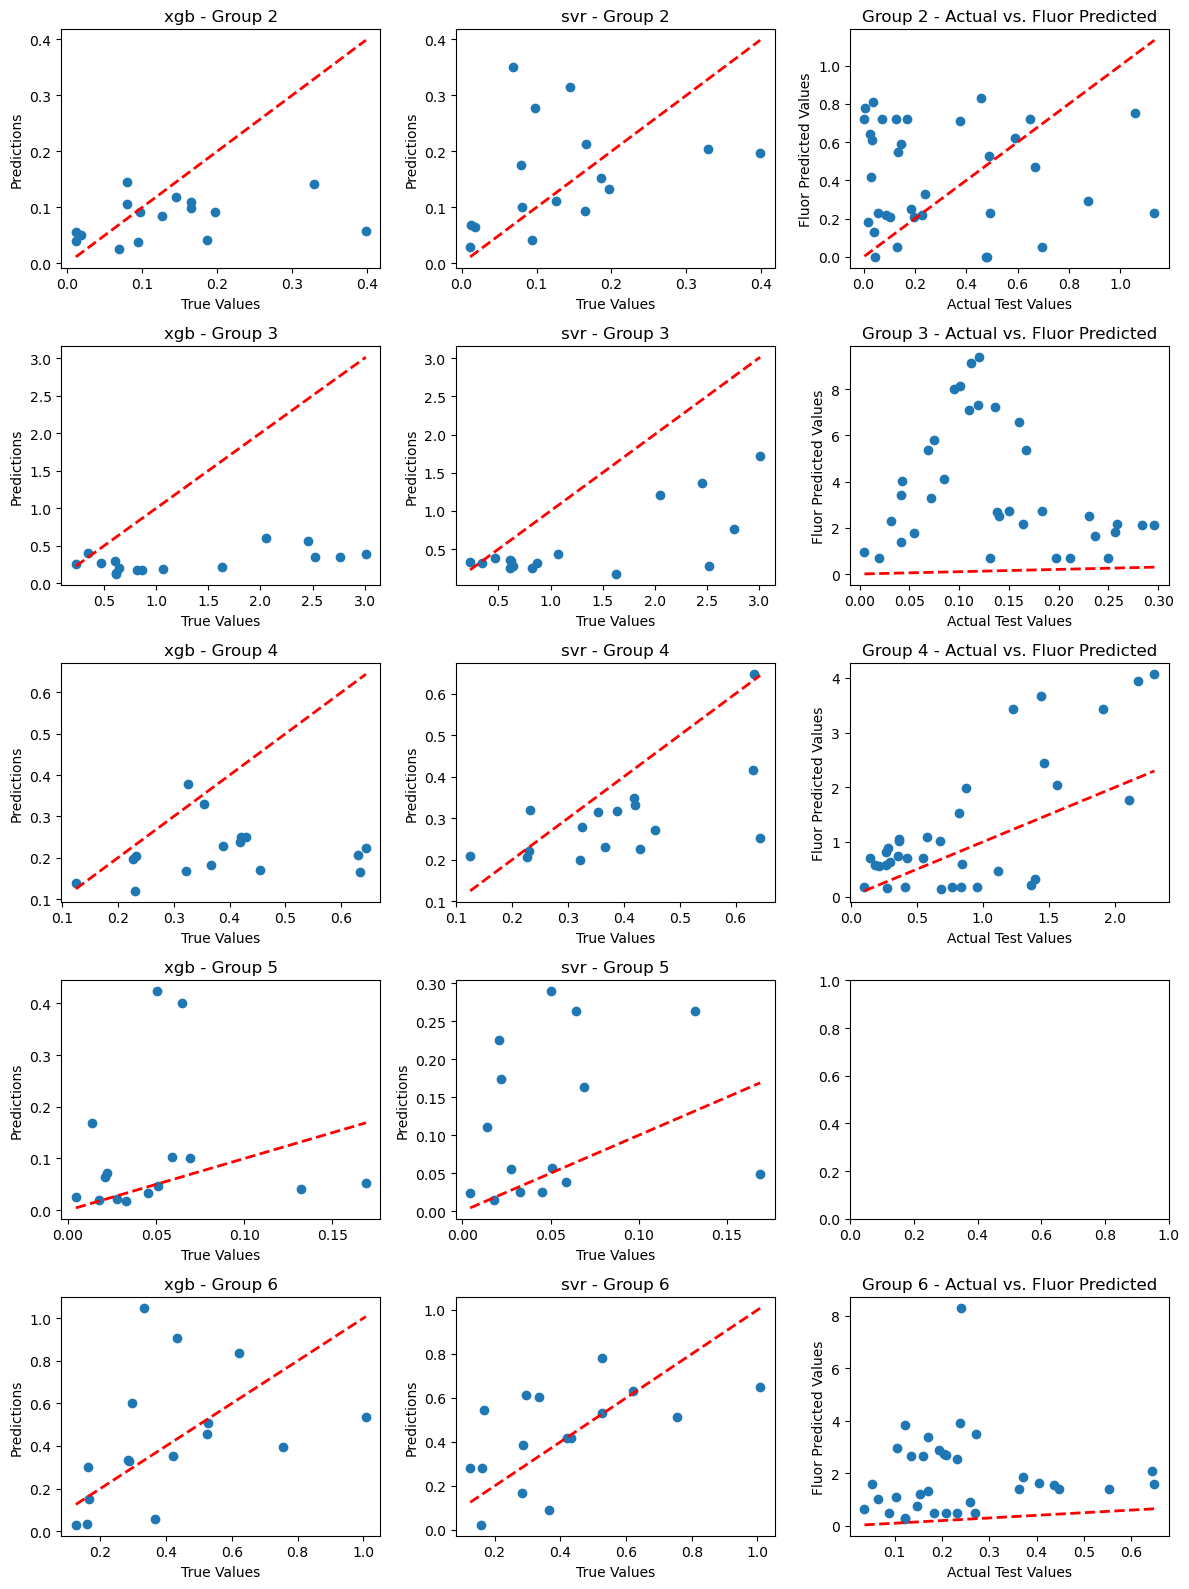

In [66]:
comparing_df_smogn = compare_all_models(regression_models_smogn, merged_val.drop(['year', 'Depth', 'week', 'month'], axis=1), fluor_test_df, fluor_groups_map, predictions_fn=np.exp, model_names=['xgb', 'svr'])

In [67]:
compare_by_mpe(merged_val, regression_models_smogn, predict_fn=np.exp)

Model         2          3          4          5          6
0   xgb  4.569385  26.660224   9.064494   6.502418  18.292116
1   svr  5.146206  19.649200   6.433184   5.223750  11.679400
2   elf  6.005671  41.314078  25.327676  23.599387  11.901138
3    lr  4.571562  38.178775   8.822994  32.836904   6.823789

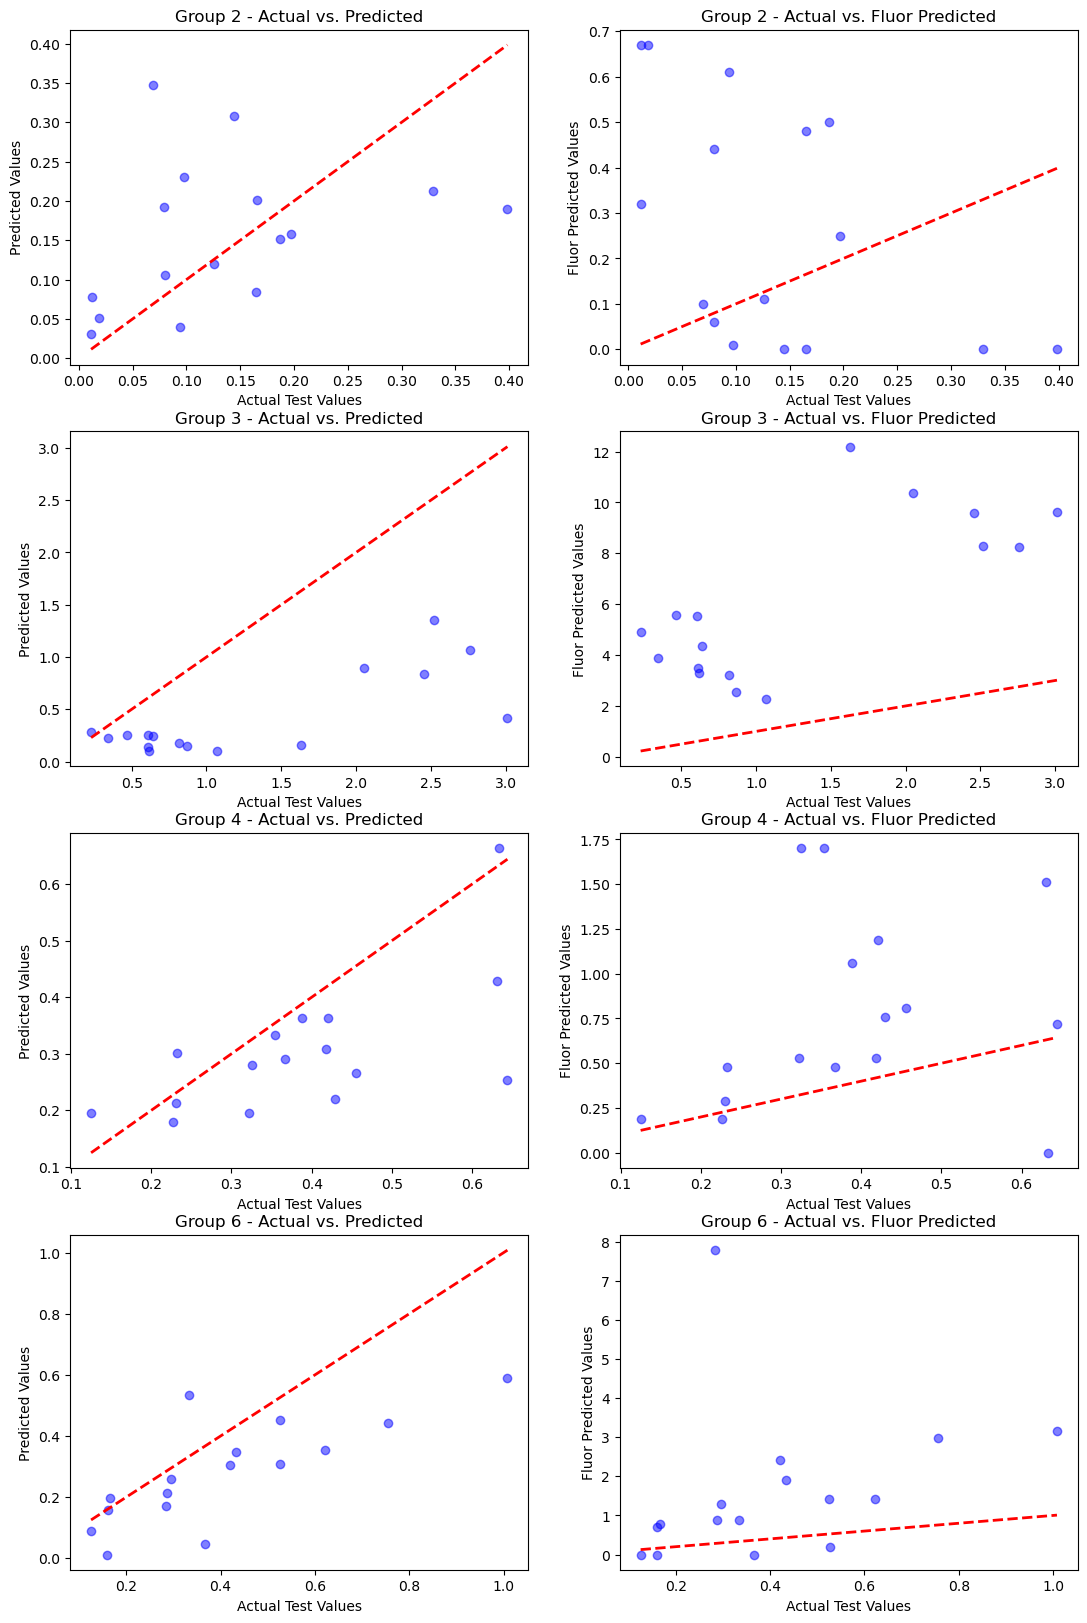

In [68]:
compare_to_fluor(regression_models['svr'], merged_val.drop(['week', 'month', 'year', 'Depth'], axis=1), fluor_groups_map, fluor_val_df, predict_fn=np.exp)

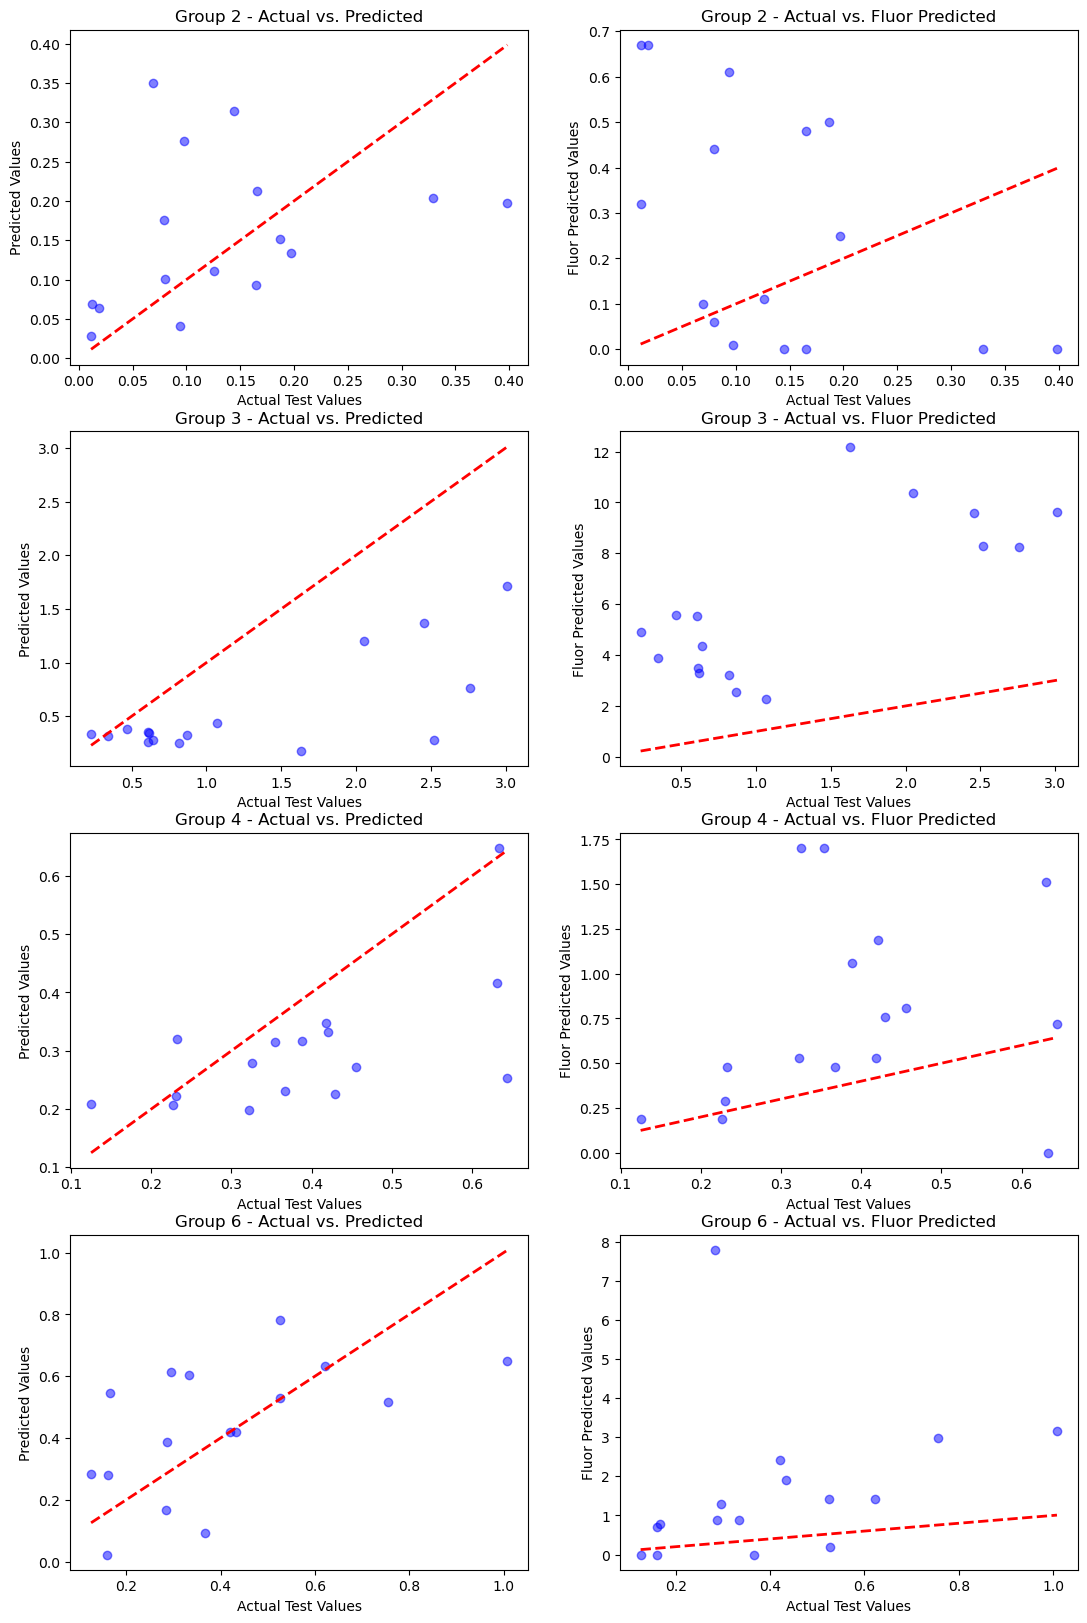

In [69]:
compare_to_fluor(regression_models_smogn['svr'], merged_val.drop(['week', 'month', 'year', 'Depth'], axis=1), fluor_groups_map, fluor_val_df, predict_fn=np.exp)